# Bayesian Censoring Data Modeling

In this notebook, we explore using Bayesian modeling to estimate the parameters of a censored data set. These datasets are common in many fields, including survival analysis and supply chain management. I was motivated to write this notebook after reading the excellent blog post ["Modeling Anything With First Principles: Demand under extreme stockouts"](https://kylejcaron.github.io/posts/censored_demand/2024-02-06-censored-demand.html) by [Kyle Caron](https://kylejcaron.github.io/) where he uses these techniques to model and balance demand under extreme stockouts and other constraints.

We do not provide a complete theoretical introduction to censoring modeling but focus on the fundamental concepts we illustrate via explicit code implementations. We work out two examples: a continuous and a discrete likelihood. Both cases follow the same structure but differ in a small detail, which we want to highlight. We use [`NumPyro`](http://num.pyro.ai/) to build the models *by hand* by using the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) (CDF) [parametrization](https://forum.pyro.ai/t/censoring-model-observing-on-delta/1811) described in Uber's blog post ["Modeling Censored Time-to-Event Data Using Pyro, an Open Source Probabilistic Programming Language"](https://www.uber.com/en-DE/blog/modeling-censored-time-to-event-data-using-pyro/) (see [here](https://gist.github.com/hesenp/90877ea3d5801214098fecd3b9e089bc) the original gist code). We then show how we can quickly implement the same models using [`PyMC`](https://docs.pymc.io/) by leveraging the [`pm.Censored`](https://www.pymc.io/projects/docs/en/stable/api/distributions/censored.html) distribution. For a detailed example of how to use `pm.Censored` (and its implications), we refer to the example notebook ["Bayesian regression with truncated or censored data"](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-truncated-censored-regression.html) from the PyMC example gallery. From this example, we take a definition of censoring:

> **Censoring** occurs when a measurement has a sensitivity with a certain set of bounds. But rather than discard data outside these bounds, you would record a measurement at the bound which it exceeded.

Let's make this more precise and intuitive with code 💻!

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import preliz as pz
import pymc as pm
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.handlers import mask
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

---

# Part I: Continuous Distribution

We start by considering the continuous case. We assume that we have a dataset of observations $y$ that are censored from below and above at a known thresholds. We want to estimate the parameters of a distribution that generated these observations. We assume that the distribution is a gamma distribution (with parameters $\alpha$ and $\beta$), but the same approach can be used for other distributions. 

## Generate Censored Data

We generate data from a gamma distribution and we *clip* the data to be between the thresholds `lower` and `upper`. We then plot the histogram of the data and the true gamma distribution.

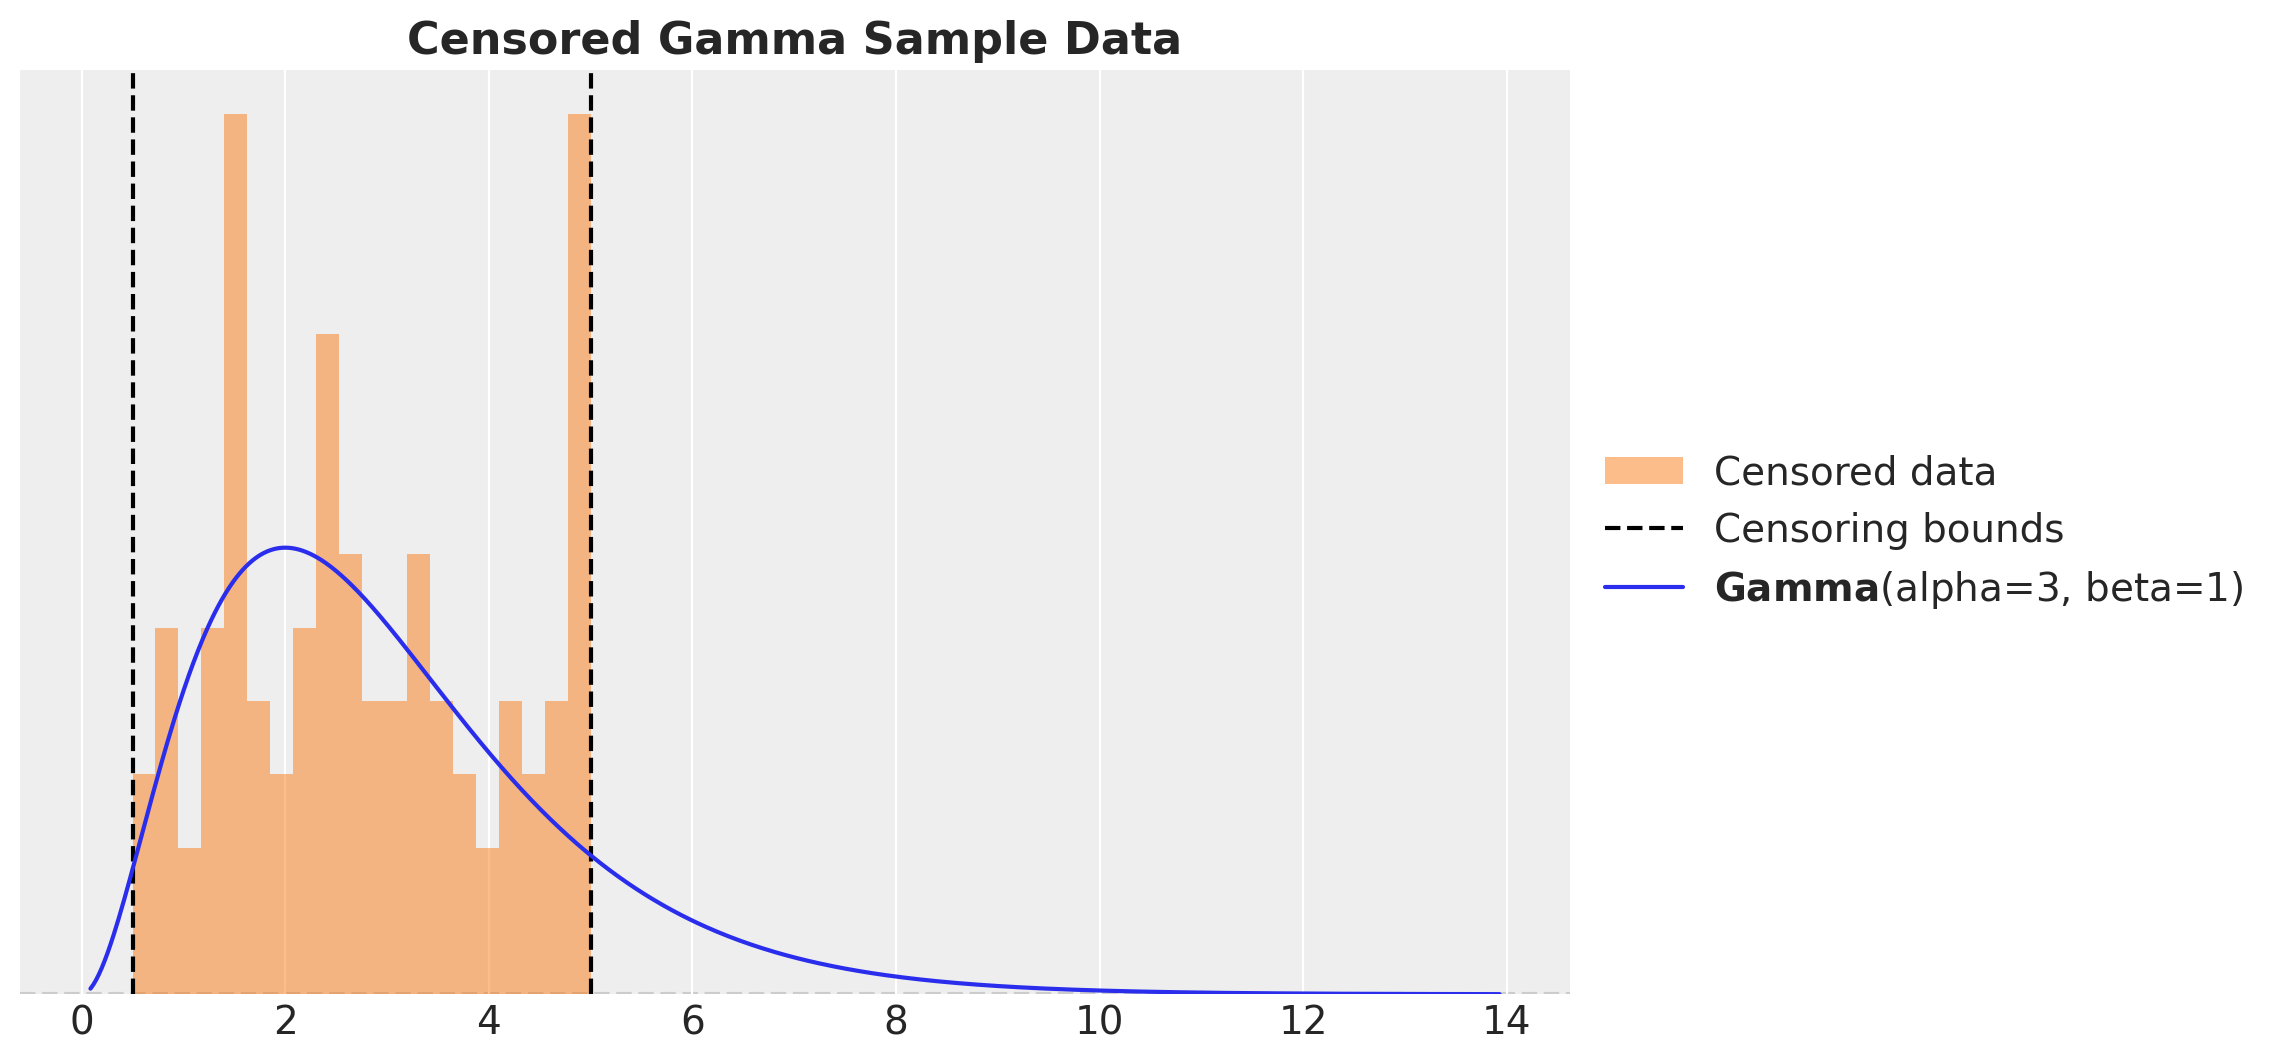

In [2]:
class CensoredGammaDataParams(BaseModel):
    alpha: float = Field(..., description="Concentration parameter", gt=0)
    beta: float = Field(..., description="Rate parameter", gt=0)
    lower: float = Field(..., description="Lower censoring bound", gt=0)
    upper: float = Field(..., description="Upper censoring bound", gt=0)
    n: int = Field(..., description="Number of samples", gt=0)


def generate_censored_gamma_samples(
    rng_key: ArrayImpl, params: CensoredGammaDataParams
) -> ArrayImpl:
    raw_samples = dist.Gamma(concentration=params.alpha, rate=params.beta).sample(
        rng_key, (params.n,)
    )
    return jnp.clip(raw_samples, params.lower, params.upper)


censored_gamma_data_params = CensoredGammaDataParams(
    alpha=3.0, beta=1.0, lower=0.5, upper=5.0, n=100
)
rng_key, rng_subkey = random.split(rng_key)
censored_gamma_samples = generate_censored_gamma_samples(
    rng_key=rng_subkey, params=censored_gamma_data_params
)

fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_gamma_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_gamma_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Gamma(
    alpha=censored_gamma_data_params.alpha, beta=censored_gamma_data_params.beta
).plot_pdf(color="C0", ax=ax)
ax.set_title("Censored Gamma Sample Data", fontsize=16, fontweight="bold");

## Naive Model

Before we implement the censoring model, we start with a naive model that does not take into account the censoring component. We simply use a gamma distribution with parameters $\alpha$ and $\beta$ to model the data. We then plot the posterior distribution of the parameters and compare them with the true values.

In [3]:
def gamma_model(y: ArrayImpl) -> None:
    alpha = numpyro.sample("alpha", dist.Exponential(1.0))
    beta = numpyro.sample("beta", dist.Exponential(1.0))
    numpyro.sample("obs", dist.Gamma(concentration=alpha, rate=beta), obs=y)


class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


inference_params = InferenceParams()

gamma_kernel = NUTS(gamma_model)
gamma_mcmc = MCMC(
    gamma_kernel,
    num_warmup=inference_params.num_warmup,
    num_samples=inference_params.num_samples,
    num_chains=inference_params.num_chains,
)
rng_key, rng_subkey = random.split(rng_key)
gamma_mcmc.run(rng_key, y=censored_gamma_samples)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

We also generate posterior predictive samples.

In [4]:
gamma_predictive = Predictive(
    model=gamma_model, posterior_samples=gamma_mcmc.get_samples()
)
rng_key, rng_subkey = random.split(rng_key)
gamma_posterior_predictive = gamma_predictive(rng_subkey, y=None)

gamma_idata = az.from_numpyro(posterior=gamma_mcmc)
gamma_idata.extend(az.from_numpyro(posterior_predictive=gamma_posterior_predictive))

Now we plot the trace and compare the true and estimated parameters.

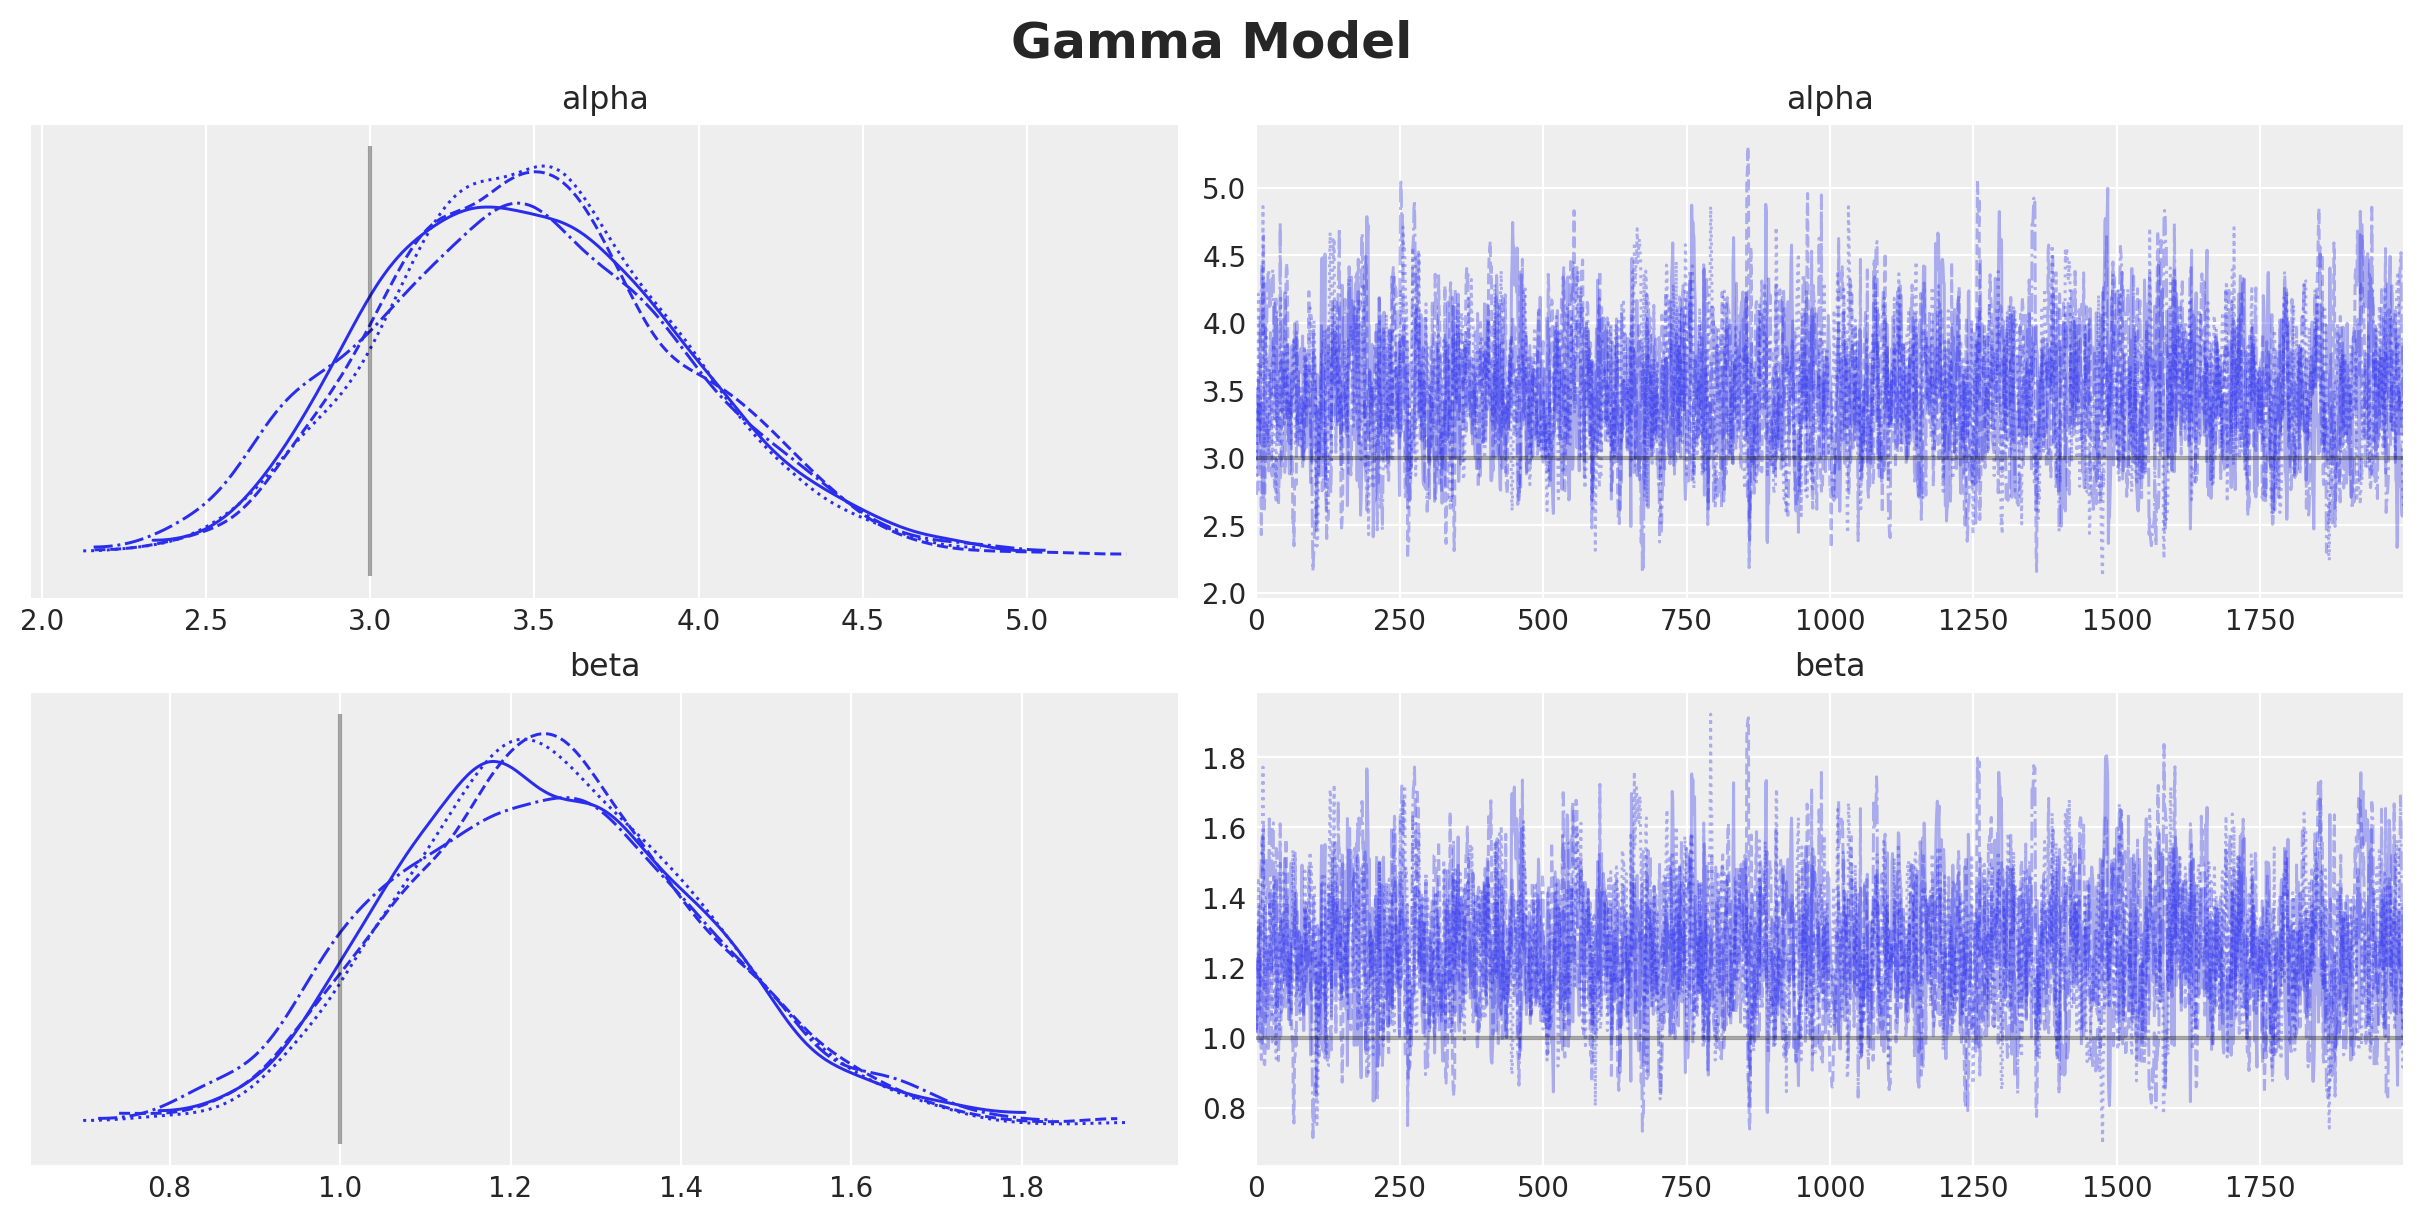

In [5]:
axes = az.plot_trace(
    data=gamma_idata,
    compact=True,
    lines=[
        ("alpha", {}, censored_gamma_data_params.alpha),
        ("beta", {}, censored_gamma_data_params.beta),
    ],
    backend_kwargs={"figsize": (12, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma Model", fontsize=18, fontweight="bold");

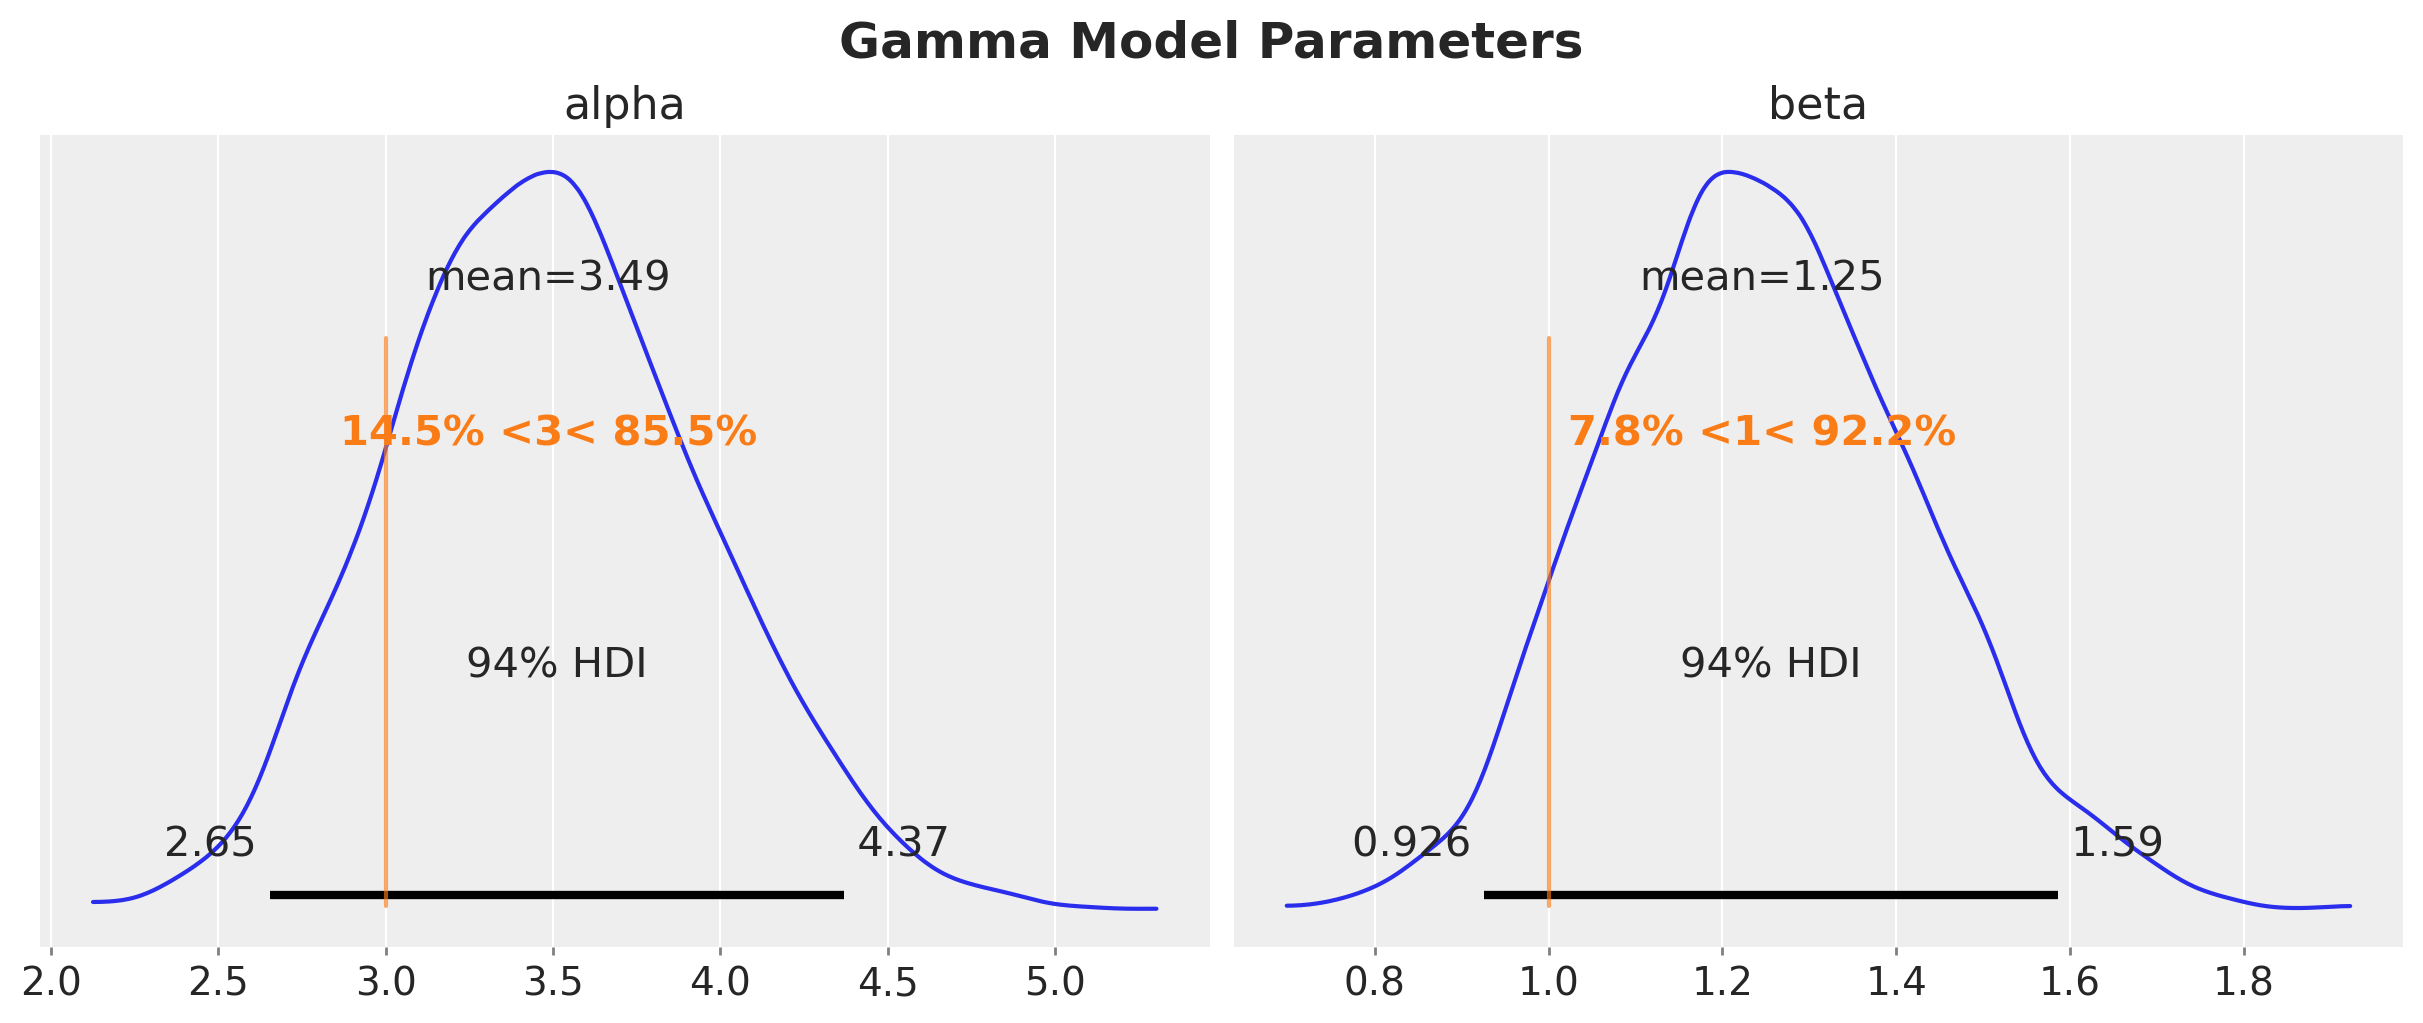

In [6]:
axes = az.plot_posterior(
    data=gamma_idata,
    ref_val=[censored_gamma_data_params.alpha, censored_gamma_data_params.beta],
    round_to=3,
    figsize=(12, 5),
)
plt.gcf().suptitle("Gamma Model Parameters", fontsize=18, fontweight="bold");

Despite the fact that the true parameters are in the $94\%$ HDI, we do see a bias in the estimation of the parameters. This is expected since we are not taking into account the censoring in the model.

We can visualize the inferred distribution and compare it with the true distribution from the data generating process.

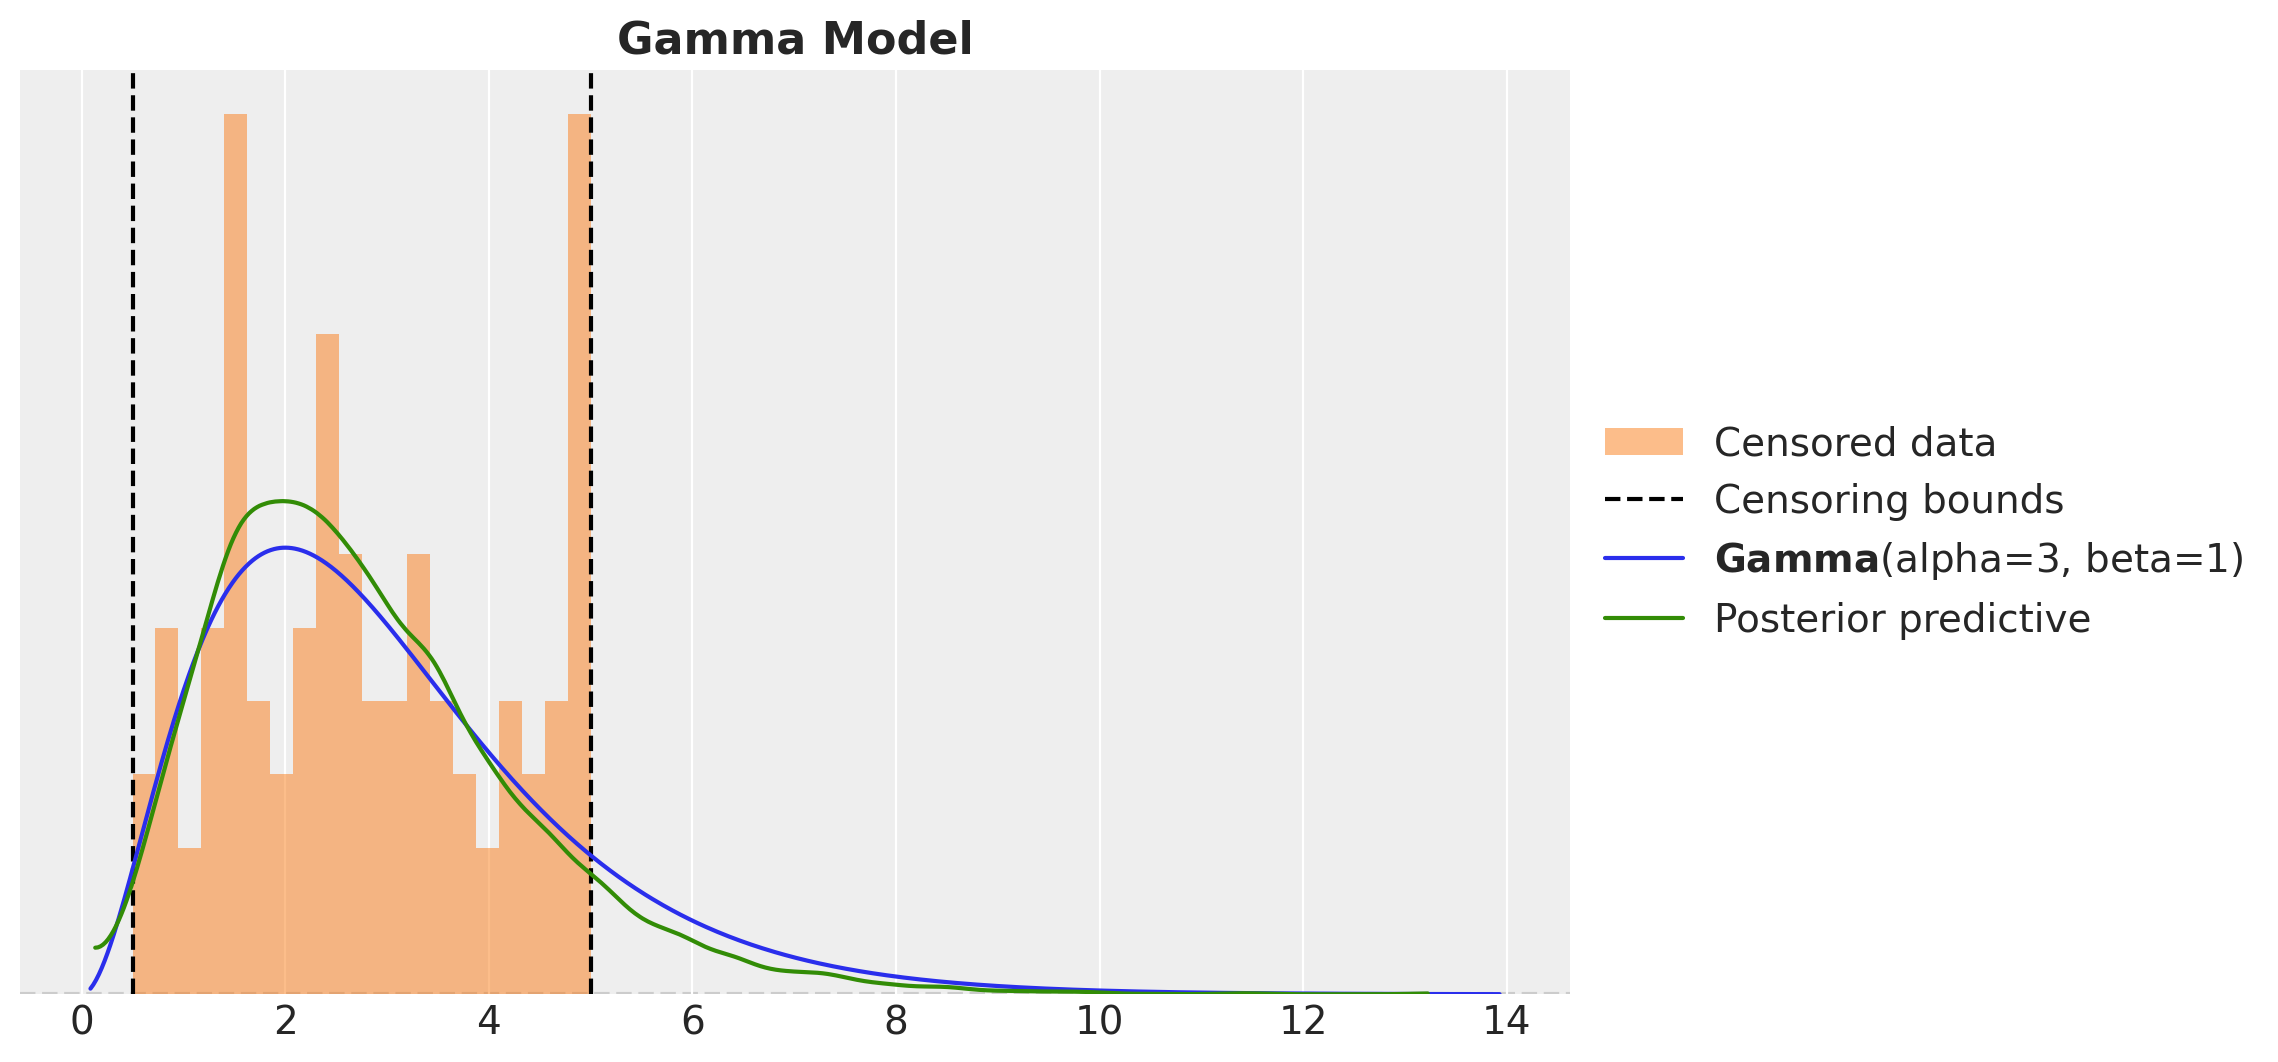

In [7]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_gamma_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_gamma_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Gamma(
    alpha=censored_gamma_data_params.alpha, beta=censored_gamma_data_params.beta
).plot_pdf(color="C0", ax=ax)
az.plot_kde(
    gamma_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    plot_kwargs={"color": "C2", "label": "Posterior predictive"},
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Gamma Model", fontsize=16, fontweight="bold");

Here see that the distributions do not match well.

## Censored Gamma Model

As mentioned in the introduction, the main idea to implement the censoring model is to use the CDF parametrization. The reason is because [the probability density function PDF of a censored distribution is](https://www.pymc.io/projects/docs/en/stable/api/distributions/censored.html)

$$
\begin{cases}
    0 & \text{for } y < lower, \\
    \text{CDF}(lower, dist) & \text{for } y = lower, \\
    \text{PDF}(y, dist) & \text{for } lower < y < upper, \\
    1-\text{CDF}(upper, dist) & \text {for } y = upper, \\
    0 & \text{for } y > upper,
\end{cases}
$$

Hence, we *just* need too implement these conditions as a custom likelihood function. To  do this in NumPyro we follow the approach described in the [gist](https://gist.github.com/hesenp/90877ea3d5801214098fecd3b9e089bc) of Uber's blog post. To follow this strategy we need an indicator function to encode the censoring:

In [8]:
def get_truncation_label(y: ArrayImpl, lower: float, upper: float) -> ArrayImpl:
    return jnp.where(y == lower, -1, jnp.where(y == upper, 1, 0))


truncation_label = get_truncation_label(
    y=censored_gamma_samples,
    lower=censored_gamma_data_params.lower,
    upper=censored_gamma_data_params.upper,
)

We are now ready to implement the model. For points in the interval $lower < y < upper$ we simply sample form a gamma distribution. On the other hand, points on the boundary follow Bernoulli distribution (if we model the censoring mask value) where the truncation probability can be parametrized by the CDF. Let's see how to do this concretely:

In [9]:
def censored_gamma_model(
    y: ArrayImpl, lower: float, upper: float, truncation_label: ArrayImpl
) -> None:
    alpha = numpyro.sample("alpha", dist.Exponential(1.0))
    beta = numpyro.sample("beta", dist.Exponential(1.0))

    distribution = dist.Gamma(concentration=alpha, rate=beta)

    with mask(mask=truncation_label == -1):
        truncation_prob_lower = distribution.cdf(lower)
        numpyro.sample(
            "truncated_label_lower", dist.Bernoulli(truncation_prob_lower), obs=1
        )

    with mask(mask=truncation_label == 0):
        numpyro.sample("obs", distribution, obs=y)

    with mask(mask=truncation_label == 1):
        truncation_prob_upper = 1 - distribution.cdf(upper)
        numpyro.sample(
            "truncated_label_upper", dist.Bernoulli(truncation_prob_upper), obs=1
        )

In [10]:
censored_gamma_kernel = NUTS(censored_gamma_model)
censored_gamma_mcmc = MCMC(
    censored_gamma_kernel,
    num_warmup=inference_params.num_warmup,
    num_samples=inference_params.num_samples,
    num_chains=inference_params.num_chains,
)
rng_key, rng_subkey = random.split(rng_key)
censored_gamma_mcmc.run(
    rng_key,
    y=censored_gamma_samples,
    lower=censored_gamma_data_params.lower,
    upper=censored_gamma_data_params.upper,
    truncation_label=truncation_label,
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

**Remark:** Note that is straightforward to add lower and upper censoring components to the model (Uber's blog post has just one censoring component).

We now fit the model and evaluate the results:

In [11]:
censored_gamma_predictive = Predictive(
    model=censored_gamma_model,
    posterior_samples=censored_gamma_mcmc.get_samples(),
    return_sites=["obs"],
)
rng_key, rng_subkey = random.split(rng_key)
censored_gamma_posterior_predictive = censored_gamma_predictive(
    rng_subkey,
    y=None,
    lower=censored_gamma_data_params.lower,
    upper=censored_gamma_data_params.upper,
    truncation_label=truncation_label,
)

censored_gamma_idata = az.from_numpyro(posterior=censored_gamma_mcmc)
censored_gamma_idata.extend(
    az.from_numpyro(posterior_predictive=censored_gamma_posterior_predictive)
)

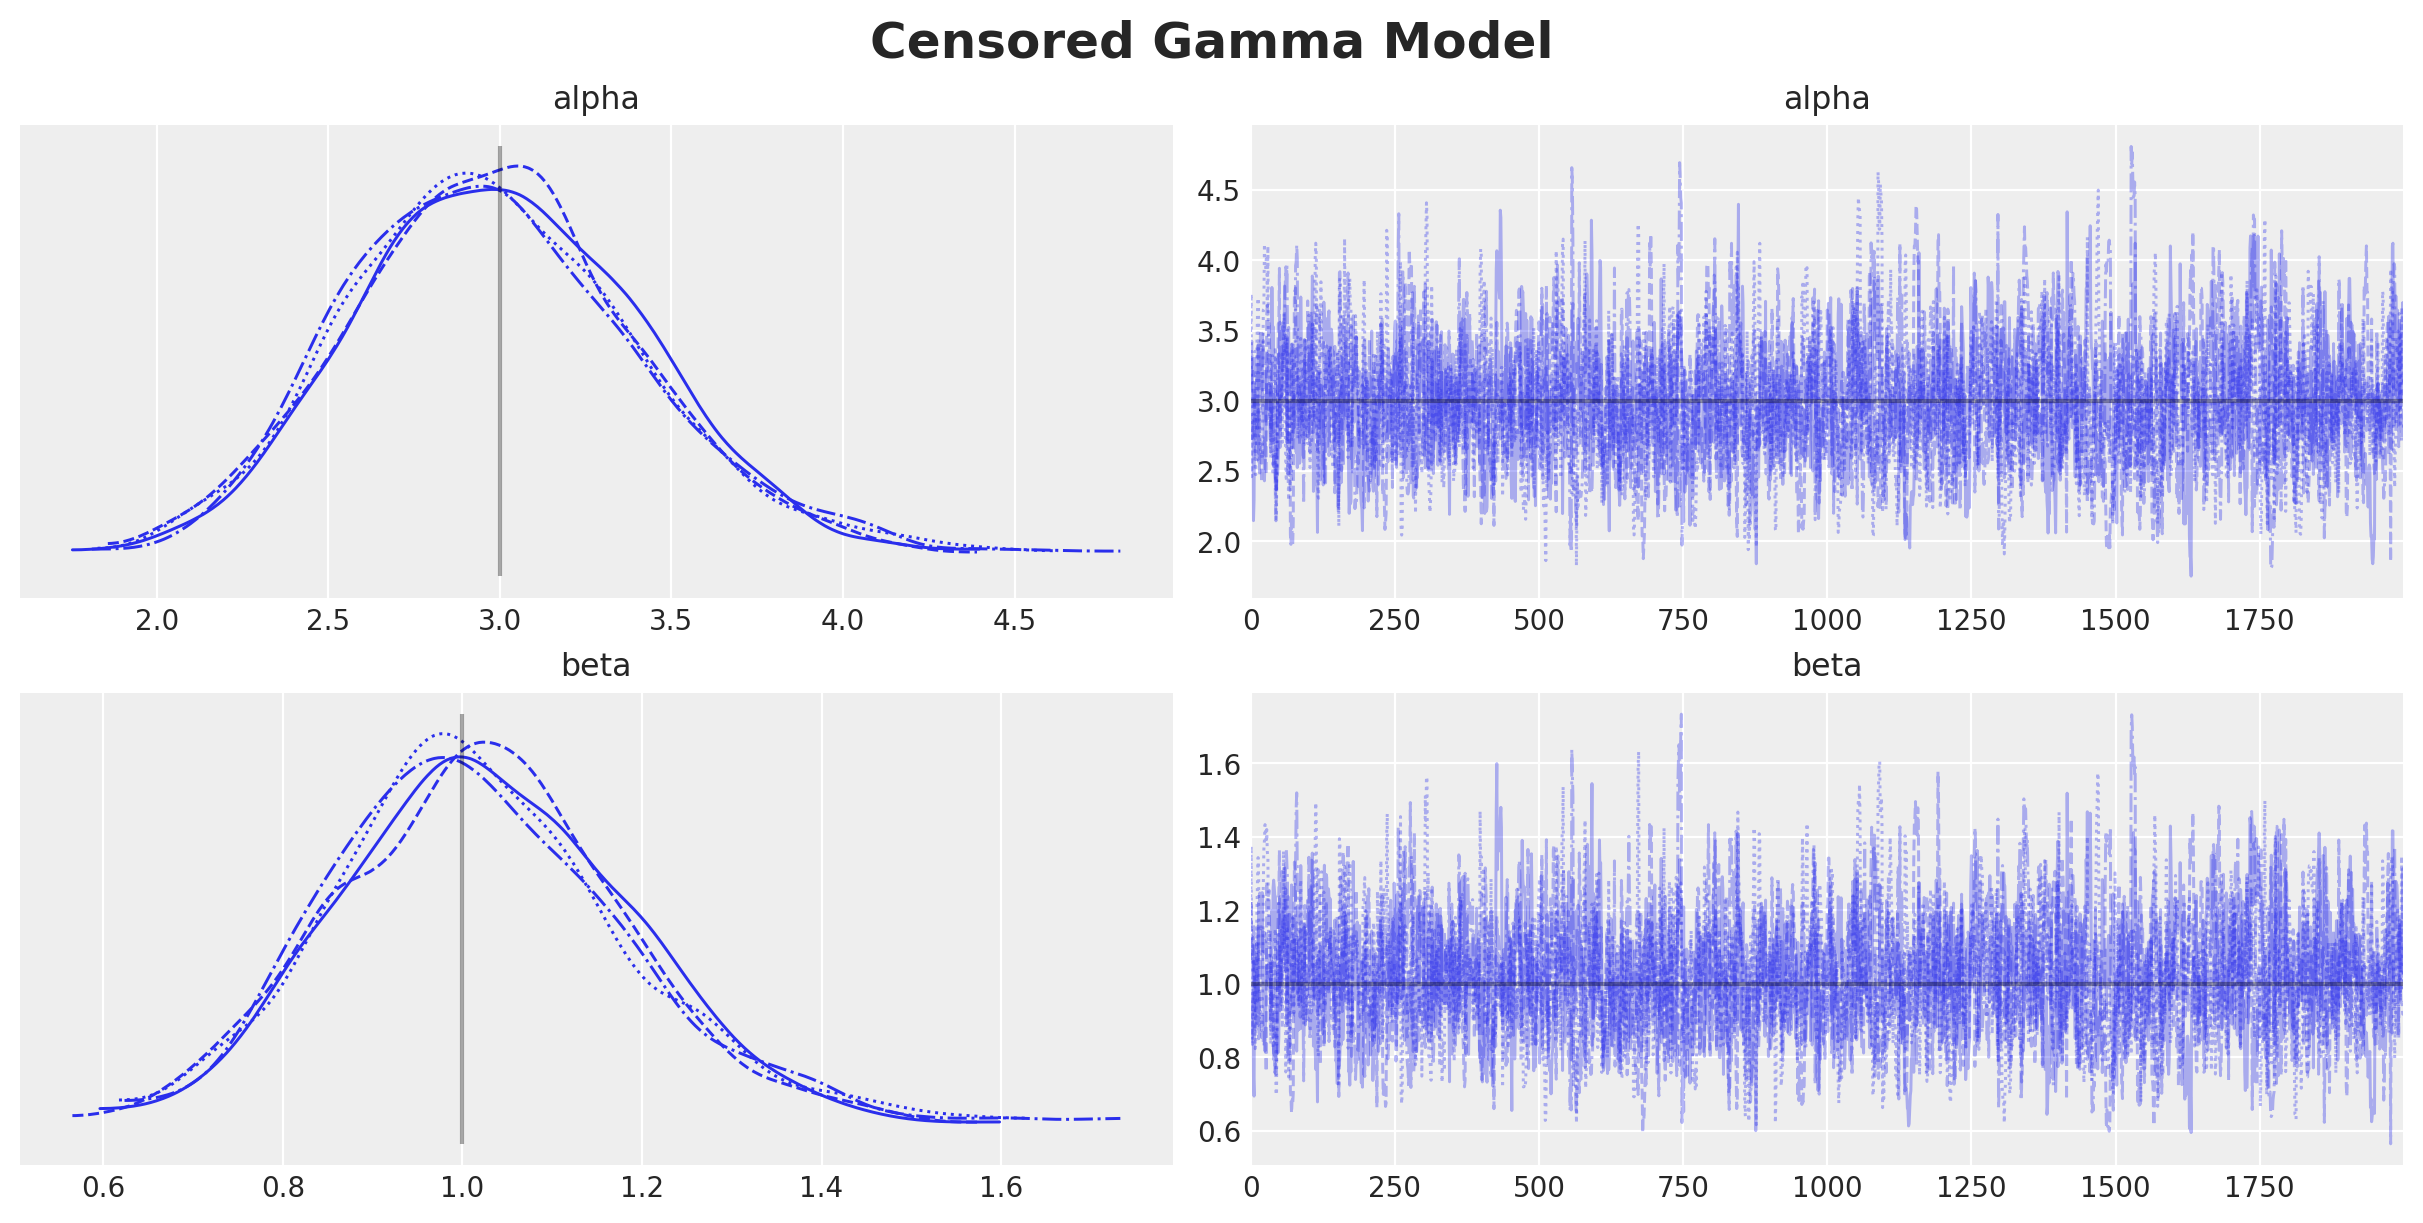

In [12]:
axes = az.plot_trace(
    data=censored_gamma_idata,
    compact=True,
    lines=[
        ("alpha", {}, censored_gamma_data_params.alpha),
        ("beta", {}, censored_gamma_data_params.beta),
    ],
    backend_kwargs={"figsize": (12, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Censored Gamma Model", fontsize=18, fontweight="bold");

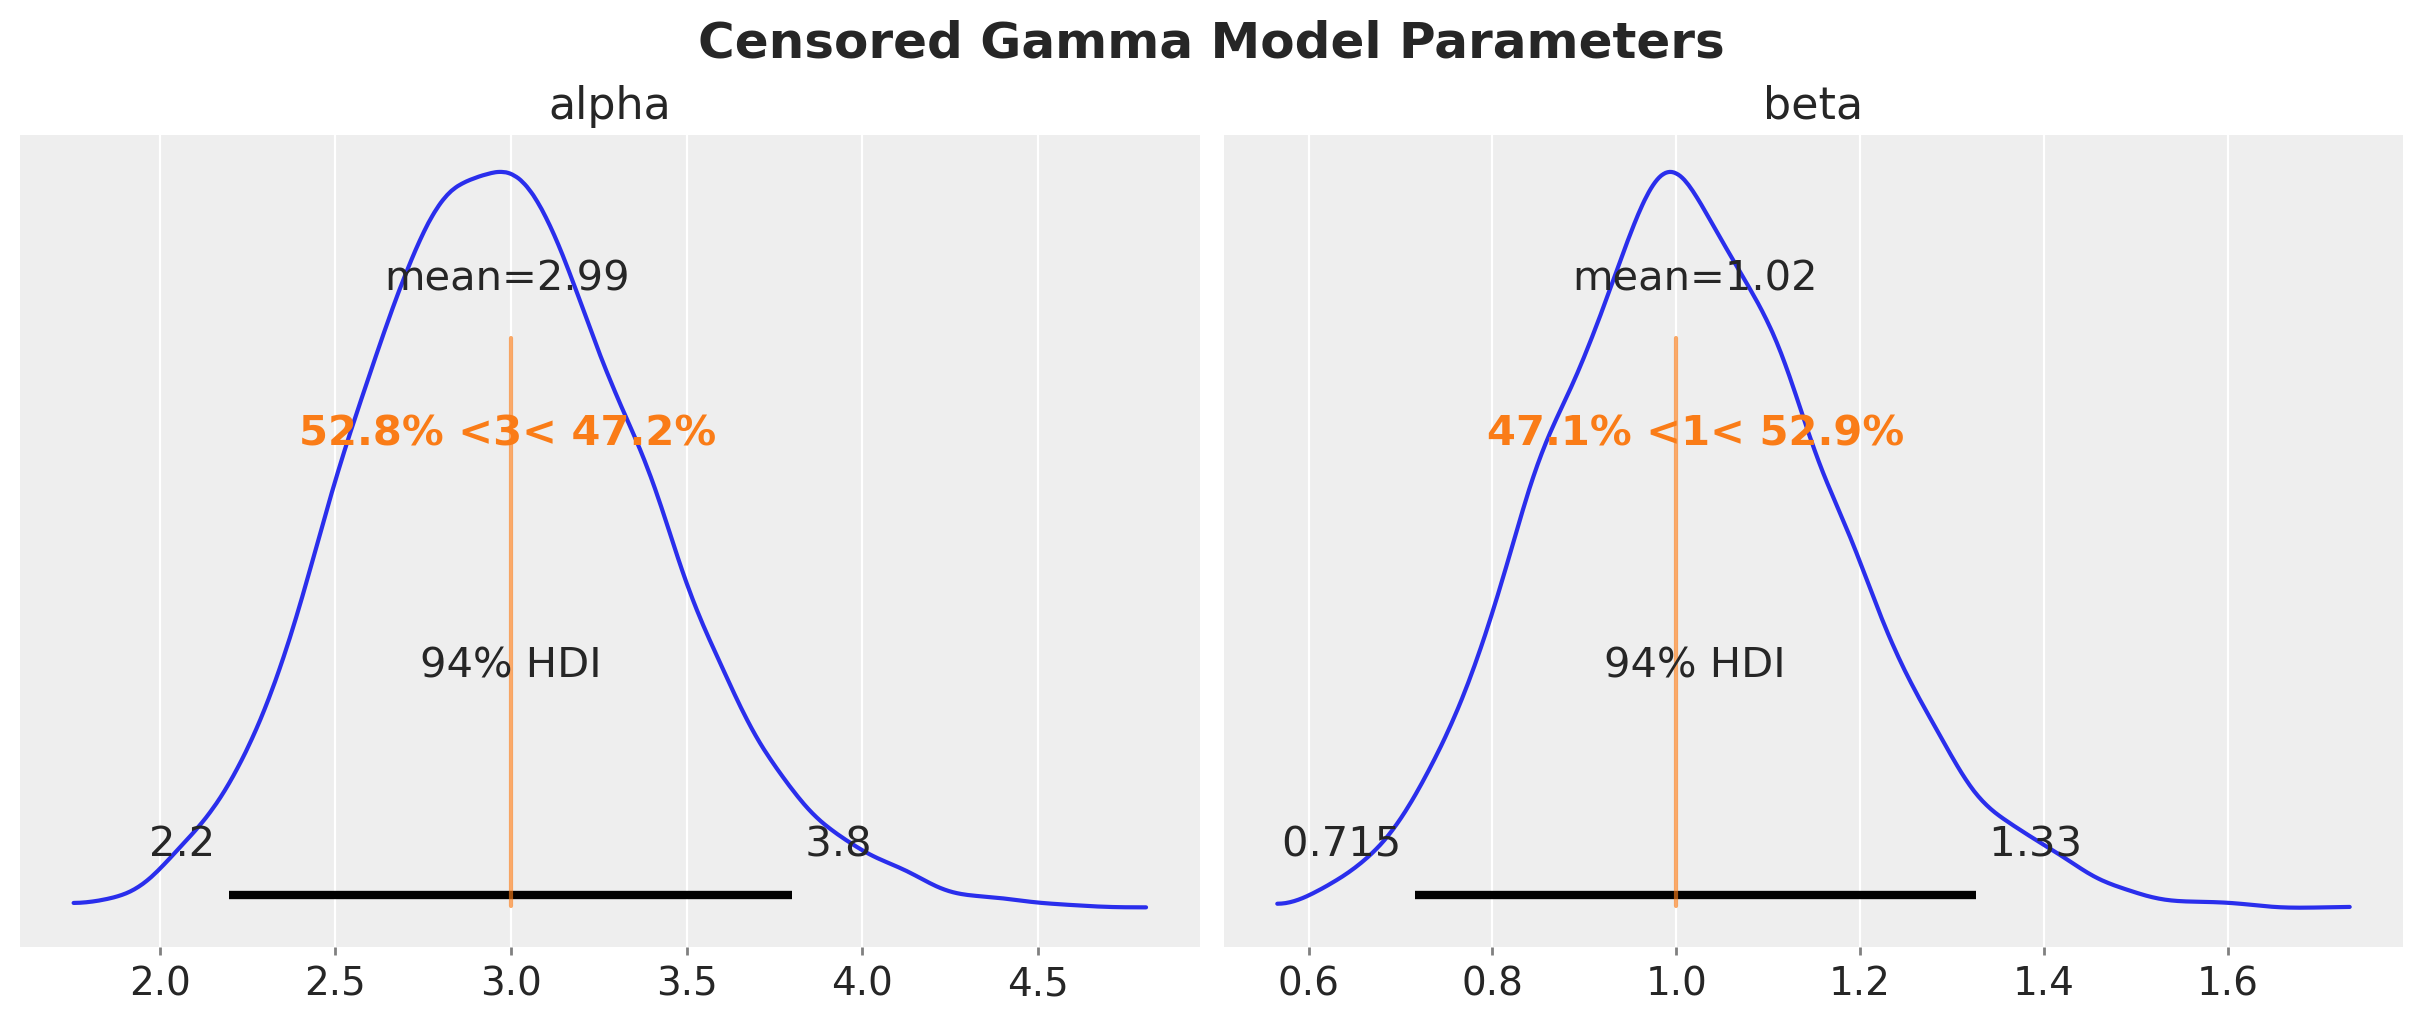

In [13]:
axes = az.plot_posterior(
    data=censored_gamma_idata,
    ref_val=[censored_gamma_data_params.alpha, censored_gamma_data_params.beta],
    round_to=3,
    figsize=(12, 5),
)
plt.gcf().suptitle("Censored Gamma Model Parameters", fontsize=18, fontweight="bold");

We clearly see that the true parameters are in correspond to the mean and mode of the posterior distribution. The censoring model is able to recover the true parameters.

As we did for the naive model, we visualize the inferred distribution and compare it with the true distribution from the data generating process.

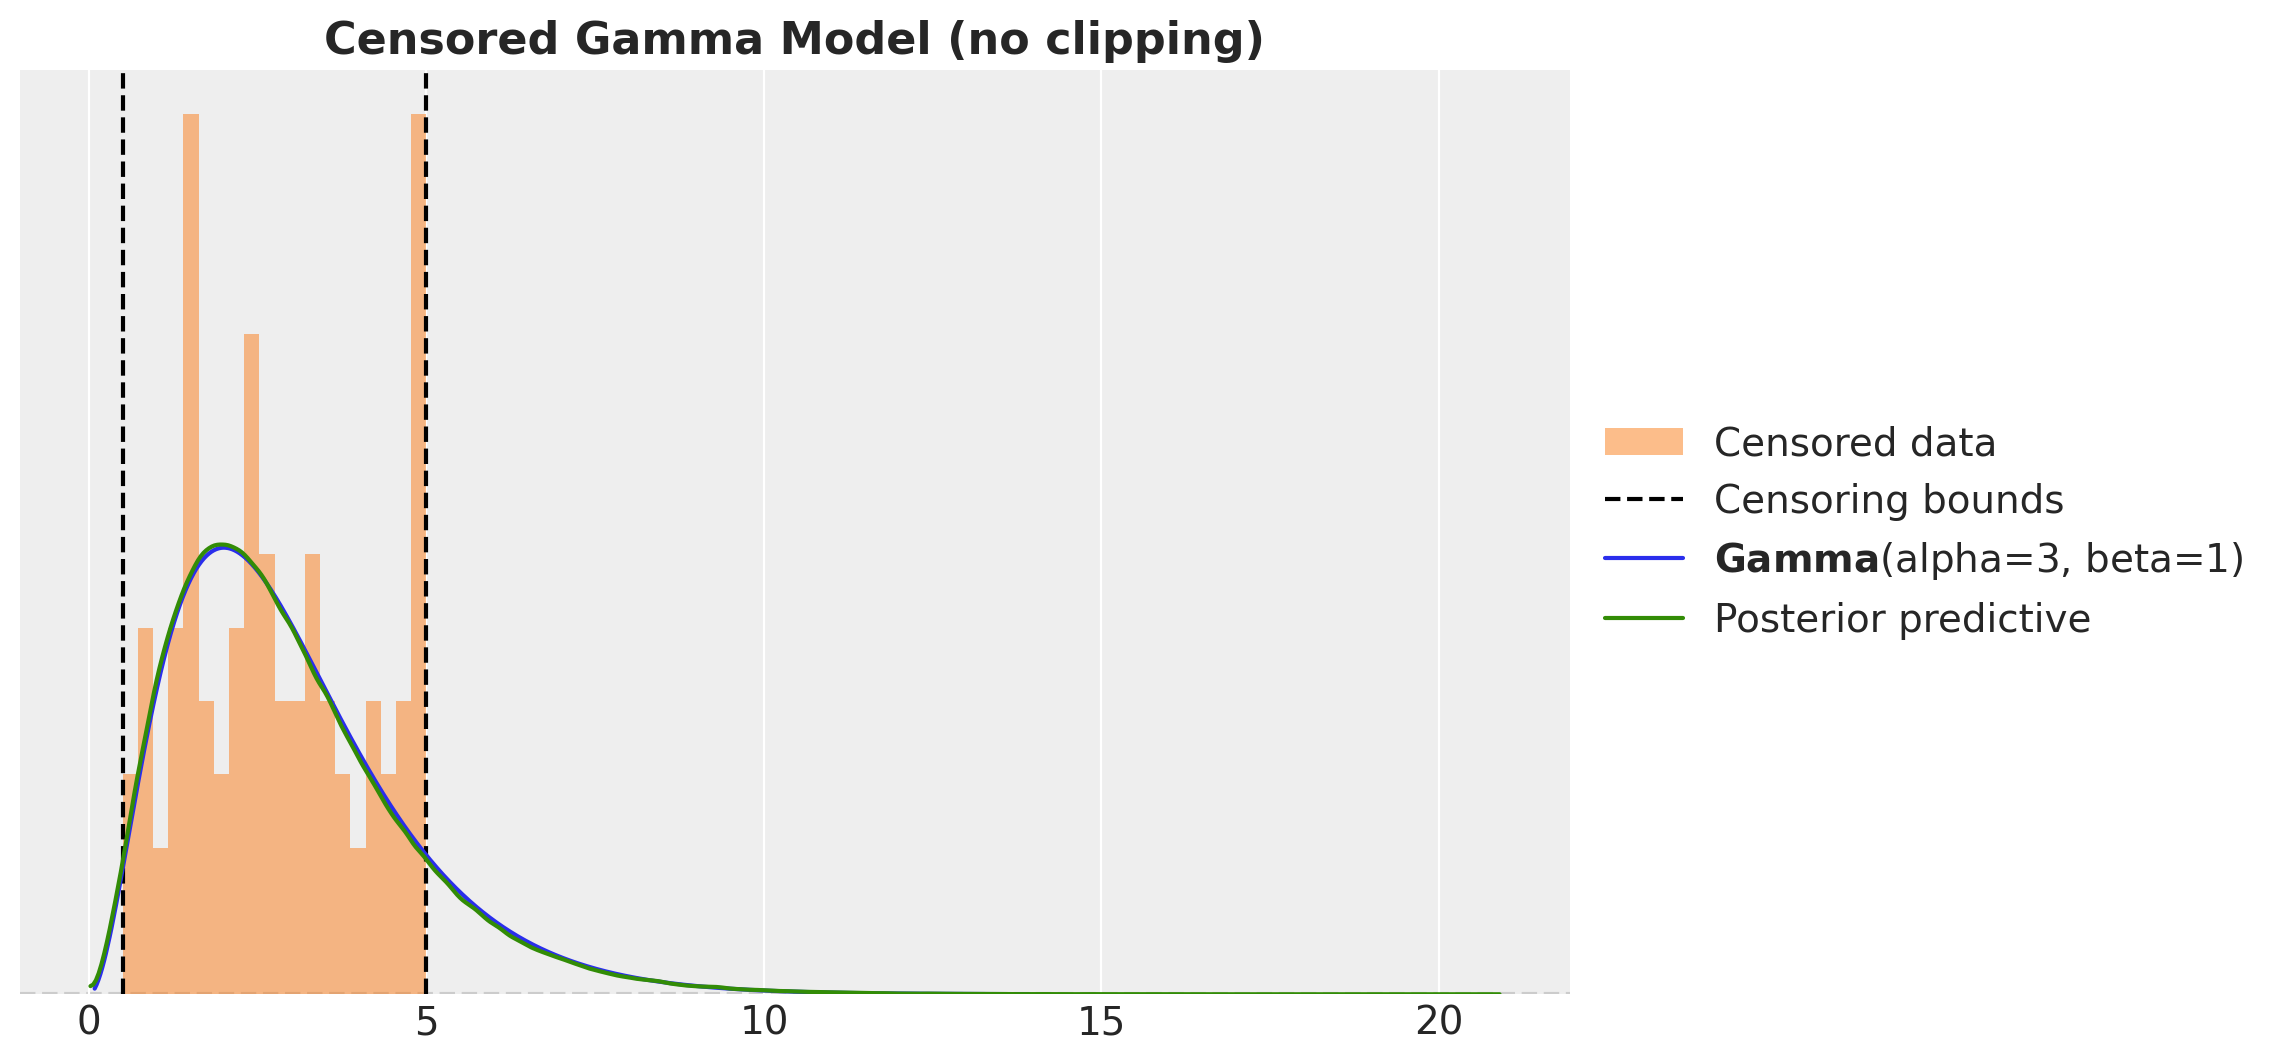

In [14]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_gamma_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_gamma_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Gamma(
    alpha=censored_gamma_data_params.alpha, beta=censored_gamma_data_params.beta
).plot_pdf(color="C0", ax=ax)
az.plot_kde(
    censored_gamma_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    plot_kwargs={"color": "C2", "label": "Posterior predictive"},
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Gamma Model (no clipping)", fontsize=16, fontweight="bold");

This looks much better than the naive model. However, there something wring as we are just sampling from the `obs` variable! We should not have posterior samples outside the censoring bounds. We can easily fix this by clipping the samples to the bounds.

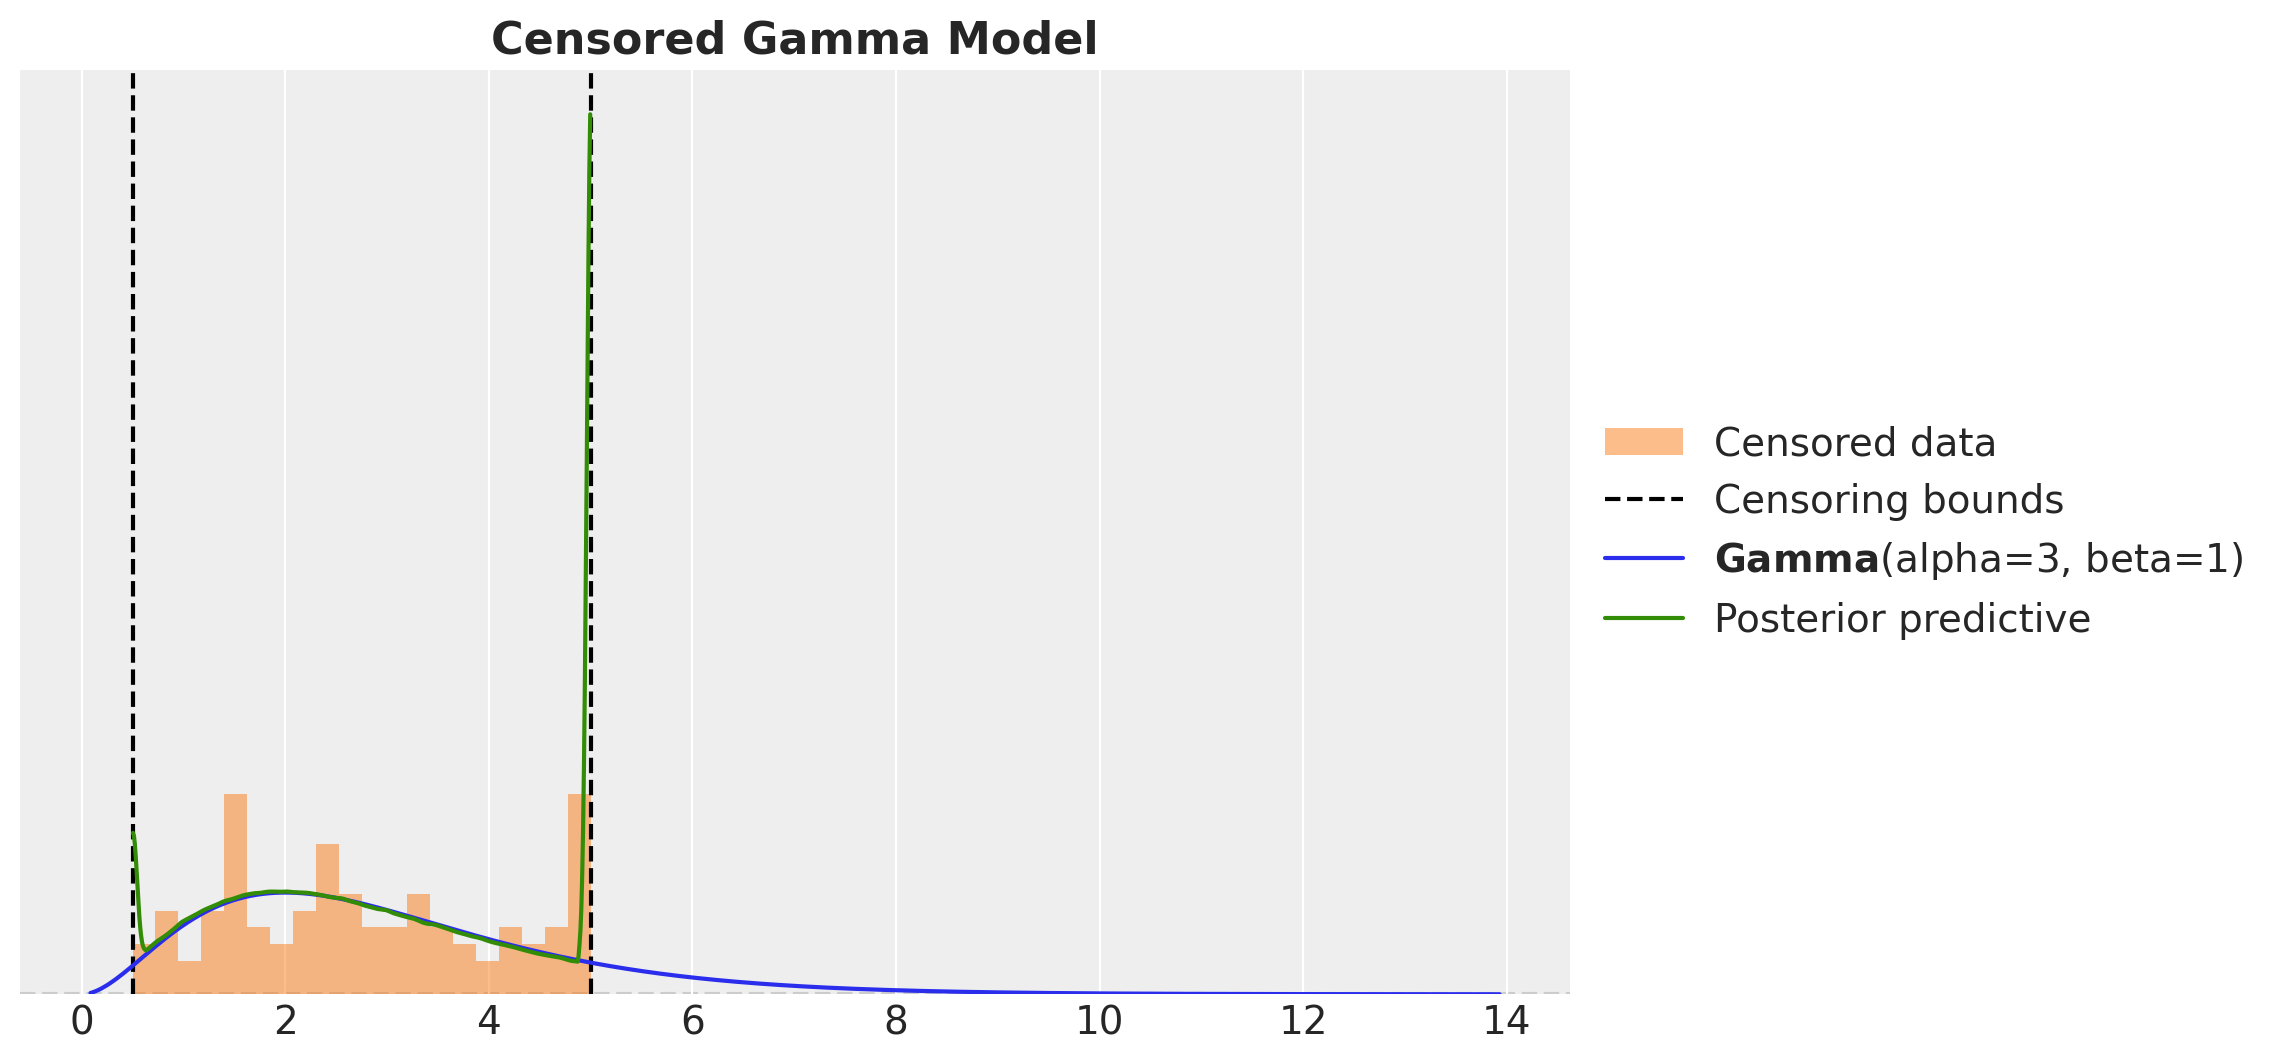

In [15]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_gamma_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_gamma_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Gamma(
    alpha=censored_gamma_data_params.alpha, beta=censored_gamma_data_params.beta
).plot_pdf(color="C0", ax=ax)
az.plot_kde(
    censored_gamma_idata["posterior_predictive"]["obs"]
    .clip(min=censored_gamma_data_params.lower, max=censored_gamma_data_params.upper)
    .to_numpy()
    .flatten(),
    plot_kwargs={"color": "C2", "label": "Posterior predictive"},
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Gamma Model", fontsize=16, fontweight="bold");

## Censored Gamma Model with PyMC

Fitting the same model in PyMC is straightforward as it provides a convenient API through the [`pm.Censored`](https://www.pymc.io/projects/docs/en/stable/api/distributions/censored.html) distribution. We get the exact same results as in NumPyro.

In [16]:
with pm.Model() as pymc_censored_gamma_model:
    alpha = pm.Exponential("alpha", lam=1.0)
    beta = pm.Exponential("beta", lam=1.0)

    distribution = pm.Gamma.dist(alpha=alpha, beta=beta)
    pm.Censored(
        "obs",
        dist=distribution,
        lower=censored_gamma_data_params.lower,
        upper=censored_gamma_data_params.upper,
        observed=censored_gamma_samples,
    )

We can even sample using the NumPyro sampler 😅!

In [17]:
rng_key, rng_subkey = random.split(rng_key)

with pymc_censored_gamma_model:
    pymc_censored_gamma_idata = pm.sample(
        tune=inference_params.num_warmup,
        draws=inference_params.num_samples,
        chains=inference_params.num_chains,
        nuts_sampler="numpyro",
        random_seed=rng_subkey[0].item(),
    )

    pymc_censored_gamma_idata.extend(
        pm.sample_posterior_predictive(trace=pymc_censored_gamma_idata)
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling: [obs]


Output()

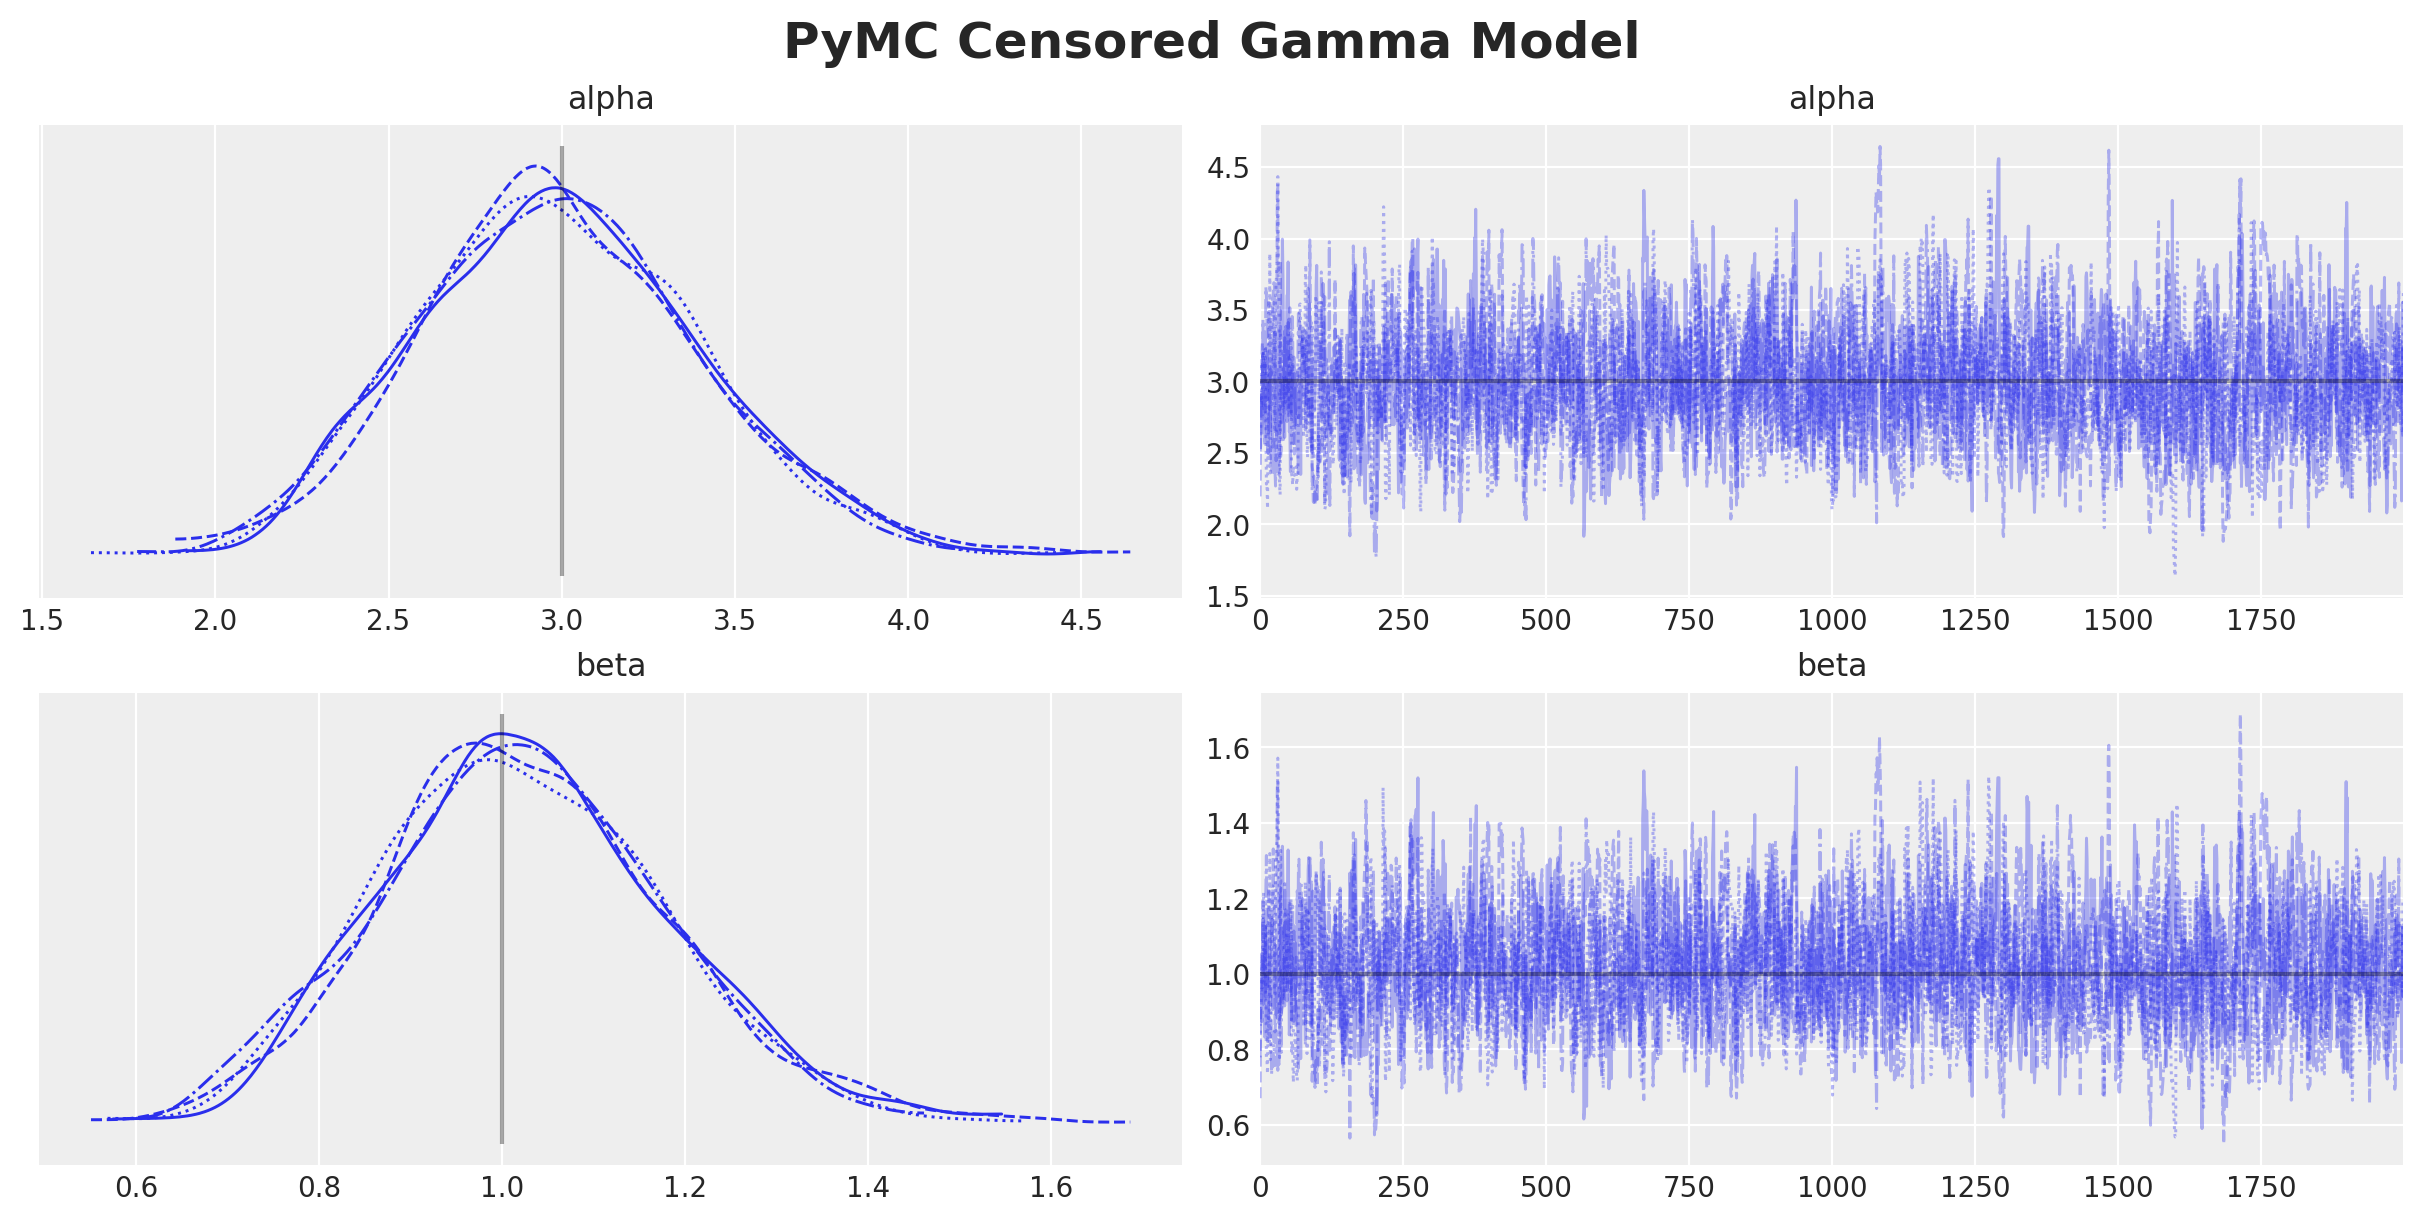

In [18]:
axes = az.plot_trace(
    data=pymc_censored_gamma_idata,
    compact=True,
    lines=[
        ("alpha", {}, censored_gamma_data_params.alpha),
        ("beta", {}, censored_gamma_data_params.beta),
    ],
    backend_kwargs={"figsize": (12, 6), "layout": "constrained"},
)
plt.gcf().suptitle("PyMC Censored Gamma Model", fontsize=18, fontweight="bold");

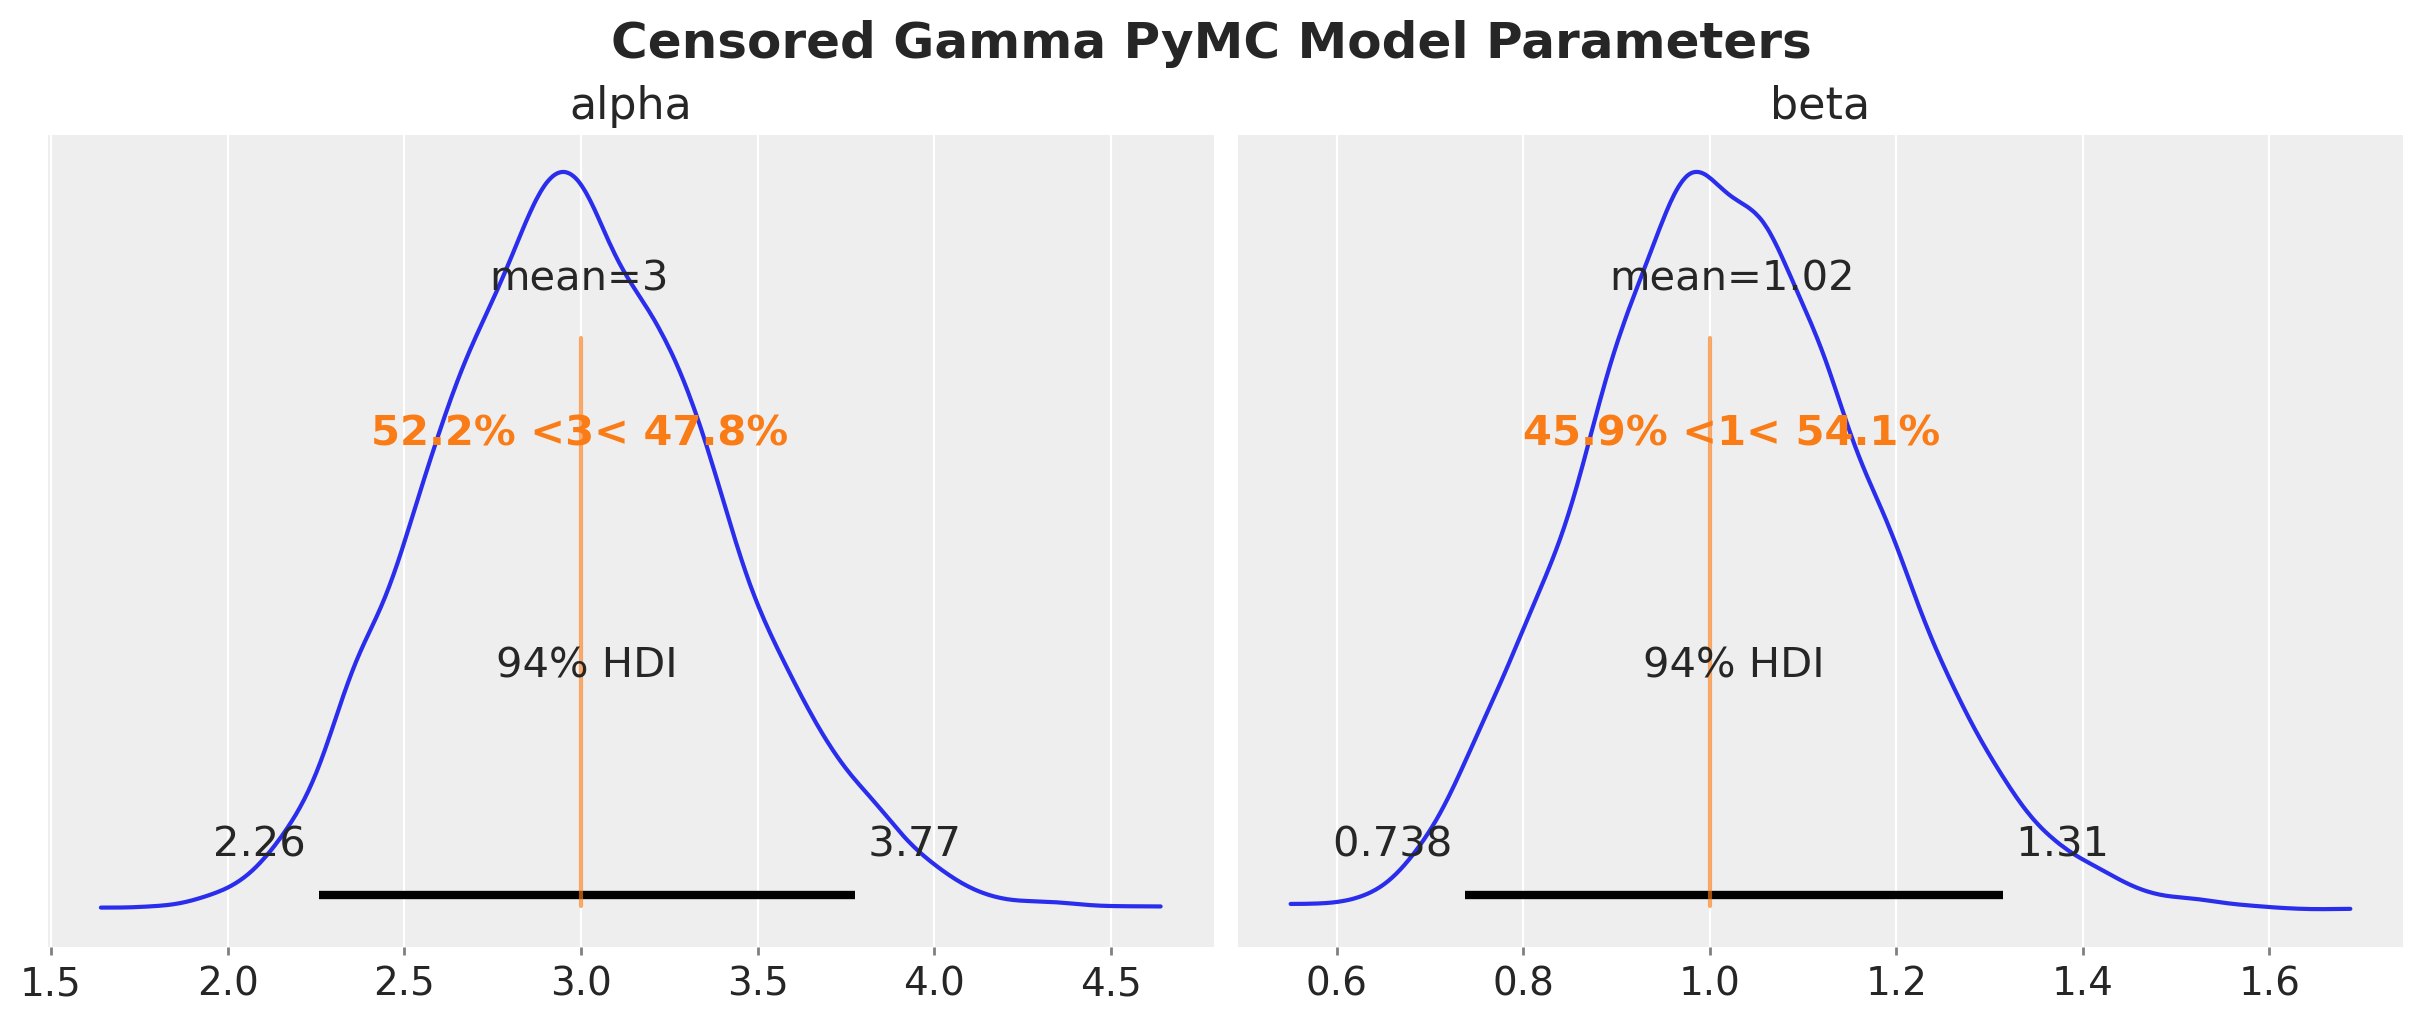

In [19]:
axes = az.plot_posterior(
    data=pymc_censored_gamma_idata,
    ref_val=[censored_gamma_data_params.alpha, censored_gamma_data_params.beta],
    round_to=3,
    figsize=(12, 5),
)
plt.gcf().suptitle(
    "Censored Gamma PyMC Model Parameters", fontsize=18, fontweight="bold"
);

We get essentially the same results as before.

Note that when we sample from the posterior predictive distribution, we do not need to clip the samples to the bounds as PyMC takes care of this for us.

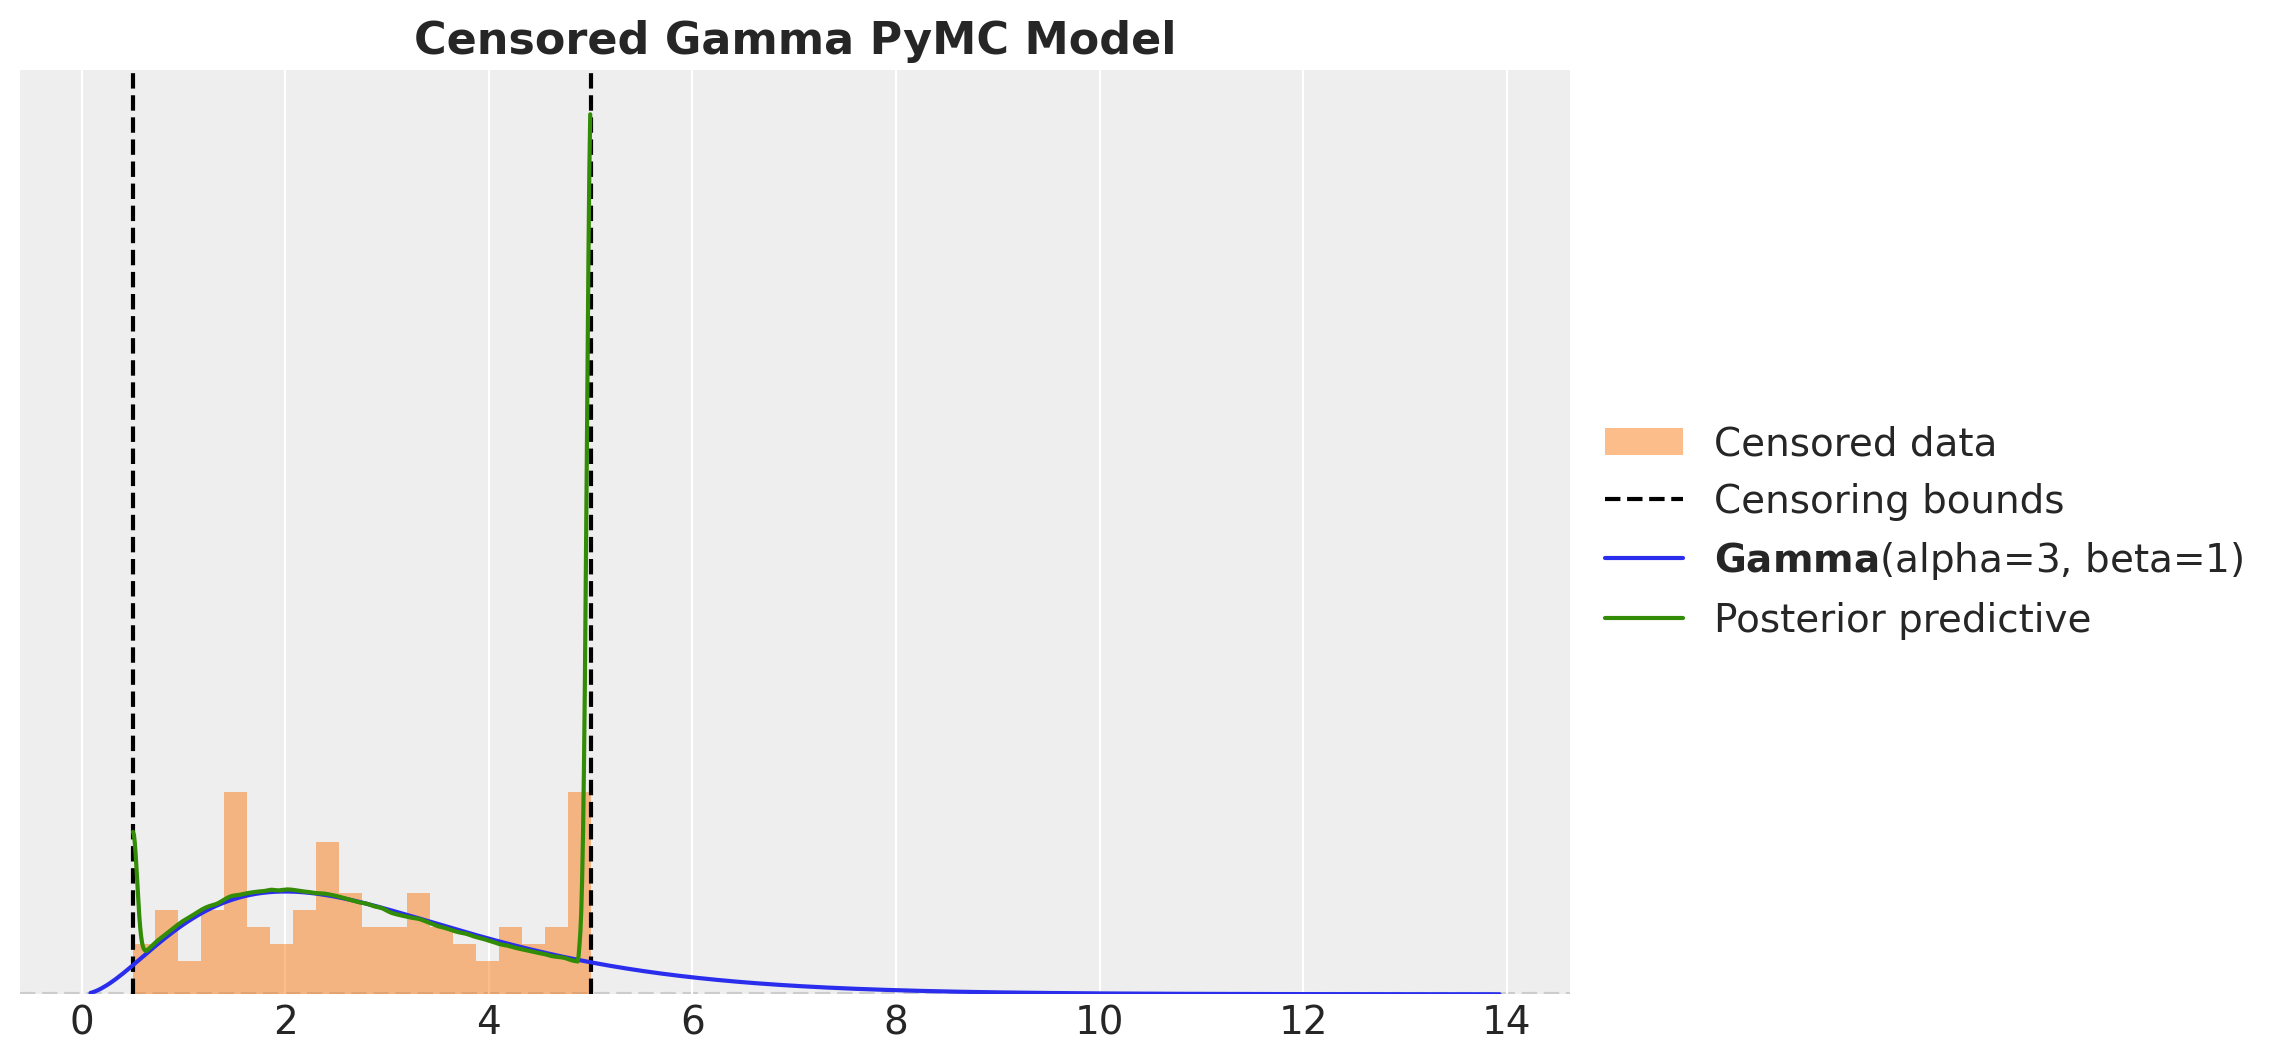

In [20]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_gamma_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_gamma_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Gamma(
    alpha=censored_gamma_data_params.alpha, beta=censored_gamma_data_params.beta
).plot_pdf(color="C0", ax=ax)
az.plot_kde(
    pymc_censored_gamma_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    plot_kwargs={"color": "C2", "label": "Posterior predictive"},
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Gamma PyMC Model", fontsize=16, fontweight="bold");

---

# Part II: Discrete Distribution

In this second part we do the same as in the first part but for a discrete distribution. Again, we assume that we have a dataset of observations $y$ that are censored from below and above at known thresholds. This time we assume the data follows a Poisson distribution (with parameter $\lambda$). We want to recover the true parameter $\lambda$. The censoring model has the same structure as in the continuous case, but there is a small detail in the upper bound. We need to add term to to the truncation probability to account for the probability of the upper bound. Specifically we need to add the probability of the upper bound using the PDF.

## Generate Censored Data

We generate data from a Poisson distribution and we *clip* the data to be between the thresholds `lower` and `upper`. We then plot the histogram of the data and the true Poisson distribution.

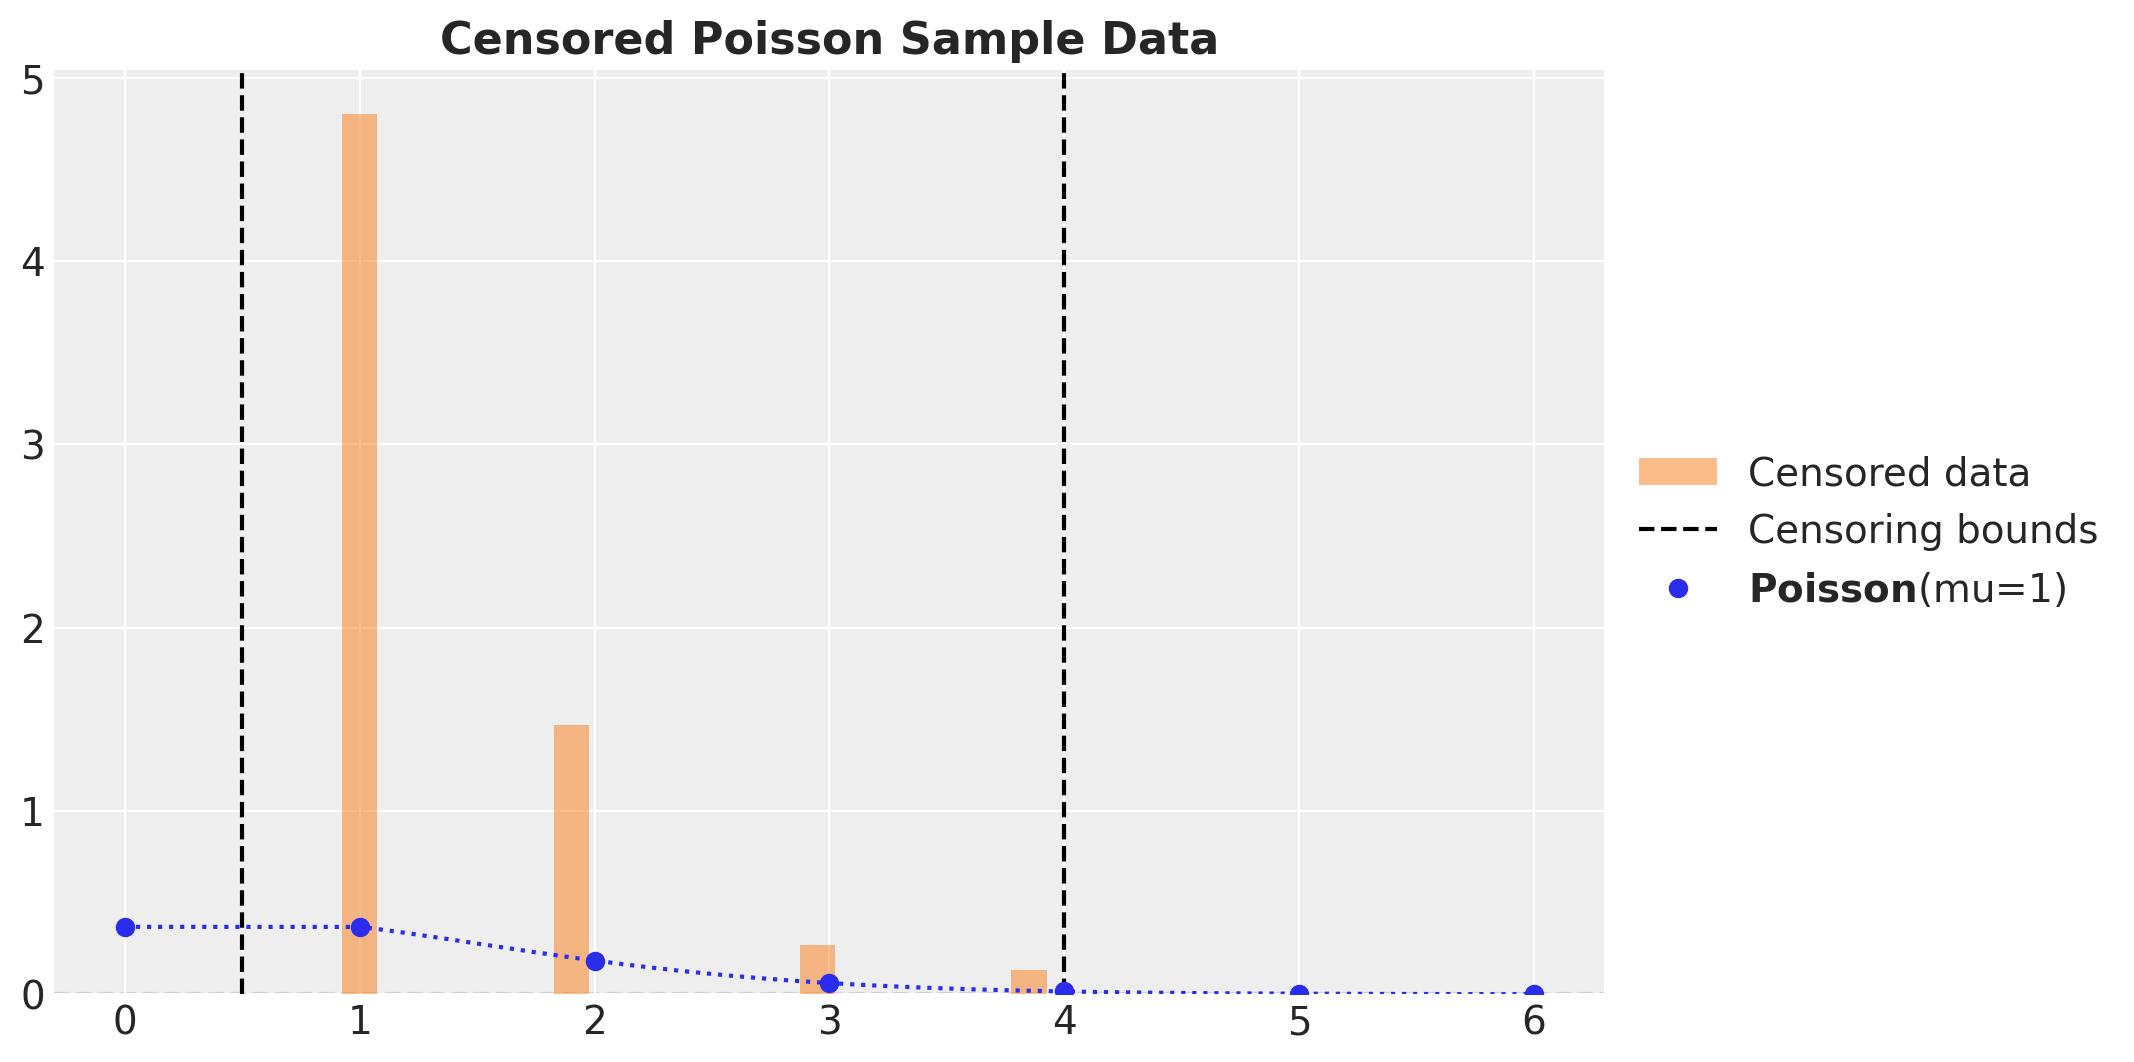

In [21]:
class CensoredPoissonDataParams(BaseModel):
    rate: float = Field(..., description="Rate parameter", gt=0)
    lower: float = Field(..., description="Lower censoring bound", gt=0)
    upper: float = Field(..., description="Upper censoring bound", gt=0)
    n: int = Field(..., description="Number of samples", gt=0)


def generate_censored_poisson_samples(
    rng_key: ArrayImpl, params: CensoredPoissonDataParams
) -> ArrayImpl:
    raw_samples = dist.Poisson(rate=params.rate).sample(rng_key, (params.n,))
    return jnp.clip(raw_samples, params.lower, params.upper)


censored_poisson_data_params = CensoredPoissonDataParams(
    rate=1, lower=1, upper=4, n=100
)
rng_key, rng_subkey = random.split(rng_key)
censored_poisson_samples = generate_censored_poisson_samples(
    rng_key=rng_subkey, params=censored_poisson_data_params
)

fig, ax = plt.subplots()
_ = ax.hist(
    censored_poisson_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
    align="left",
)
ax.axvline(censored_gamma_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_poisson_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Poisson(mu=censored_poisson_data_params.rate).plot_pdf(color="C0", ax=ax)
ax.set_title("Censored Poisson Sample Data", fontsize=16, fontweight="bold");

## Naive Model

Just as in the continuous case, we start with a naive model that does not take into account the censoring component. We simply use a Poisson distribution with parameter $\lambda$ to model the data.

In [22]:
def poisson_model(y: ArrayImpl) -> None:
    rate = numpyro.sample("rate", dist.Exponential(1.0))
    numpyro.sample("obs", dist.Poisson(rate), obs=y)


poisson_kernel = NUTS(poisson_model)
poisson_mcmc = MCMC(
    poisson_kernel,
    num_warmup=inference_params.num_warmup,
    num_samples=inference_params.num_samples,
    num_chains=inference_params.num_chains,
)
rng_key, rng_subkey = random.split(rng_key)
poisson_mcmc.run(rng_key, y=censored_poisson_samples)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [23]:
poisson_predictive = Predictive(
    model=poisson_model, posterior_samples=poisson_mcmc.get_samples()
)
rng_key, rng_subkey = random.split(rng_key)
poisson_posterior_predictive = poisson_predictive(rng_subkey, y=None)

poisson_idata = az.from_numpyro(posterior=poisson_mcmc)
poisson_idata.extend(az.from_numpyro(posterior_predictive=poisson_posterior_predictive))

Text(0.5, 0.98, 'Poisson Model')

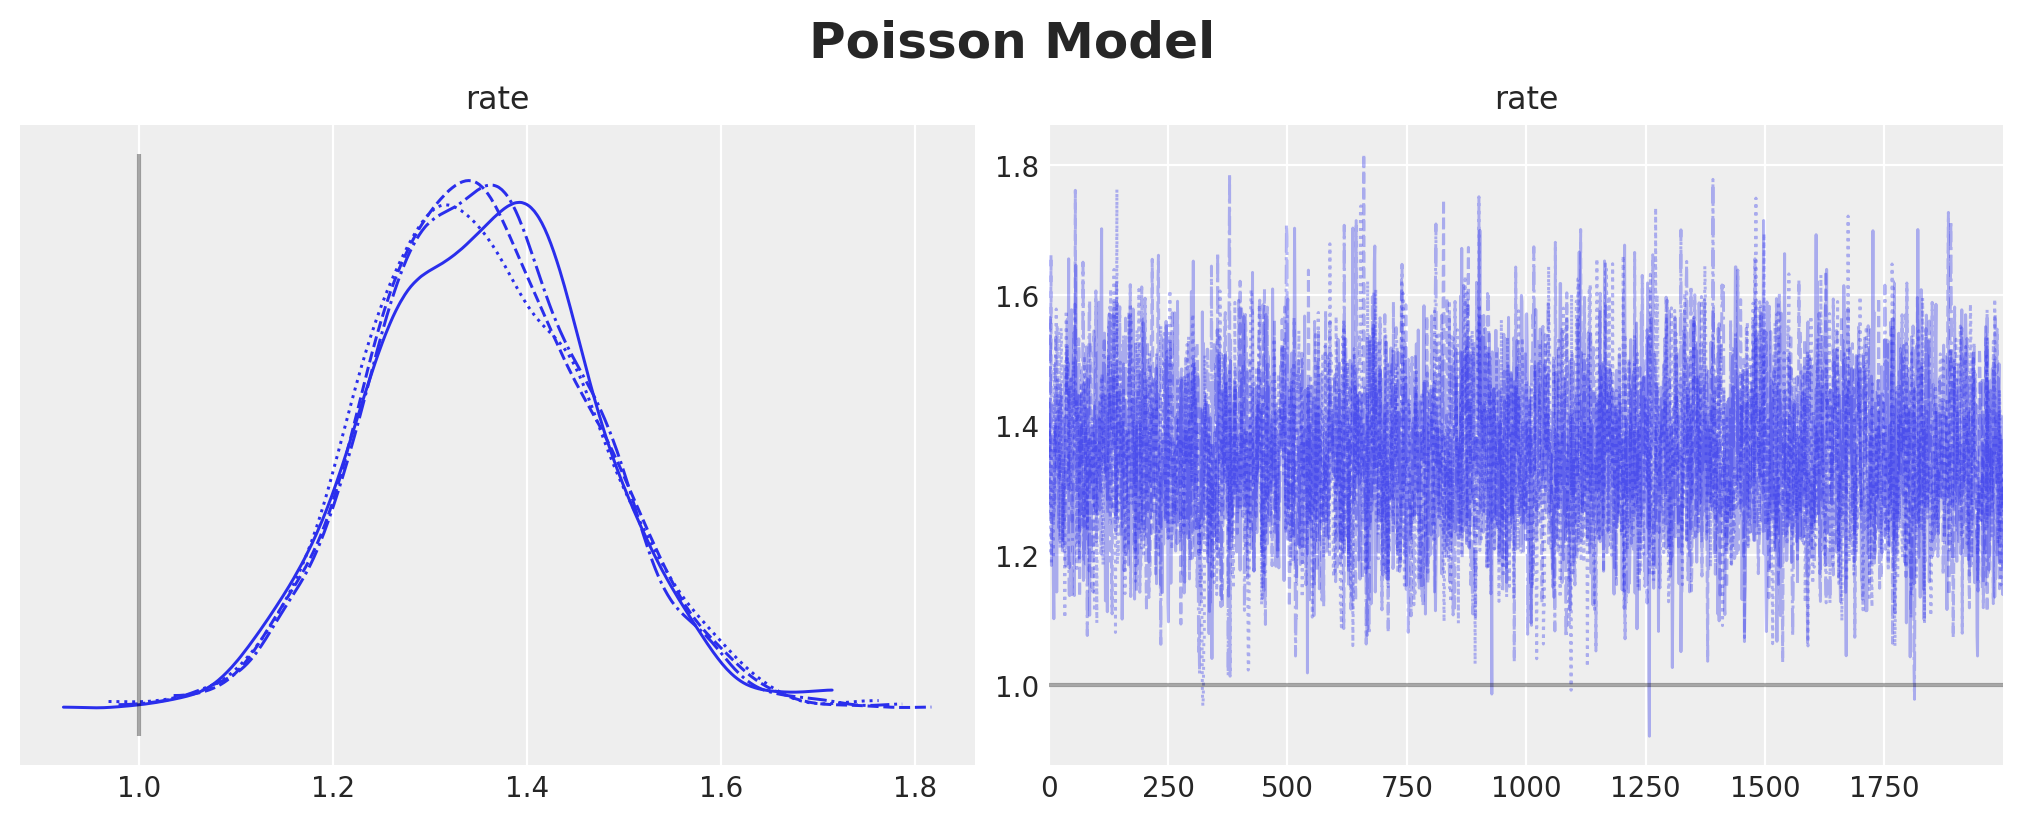

In [24]:
axes = az.plot_trace(
    data=poisson_idata,
    compact=True,
    lines=[("rate", {}, censored_poisson_data_params.rate)],
    backend_kwargs={"figsize": (10, 4), "layout": "constrained"},
)
plt.gcf().suptitle("Poisson Model", fontsize=18, fontweight="bold")

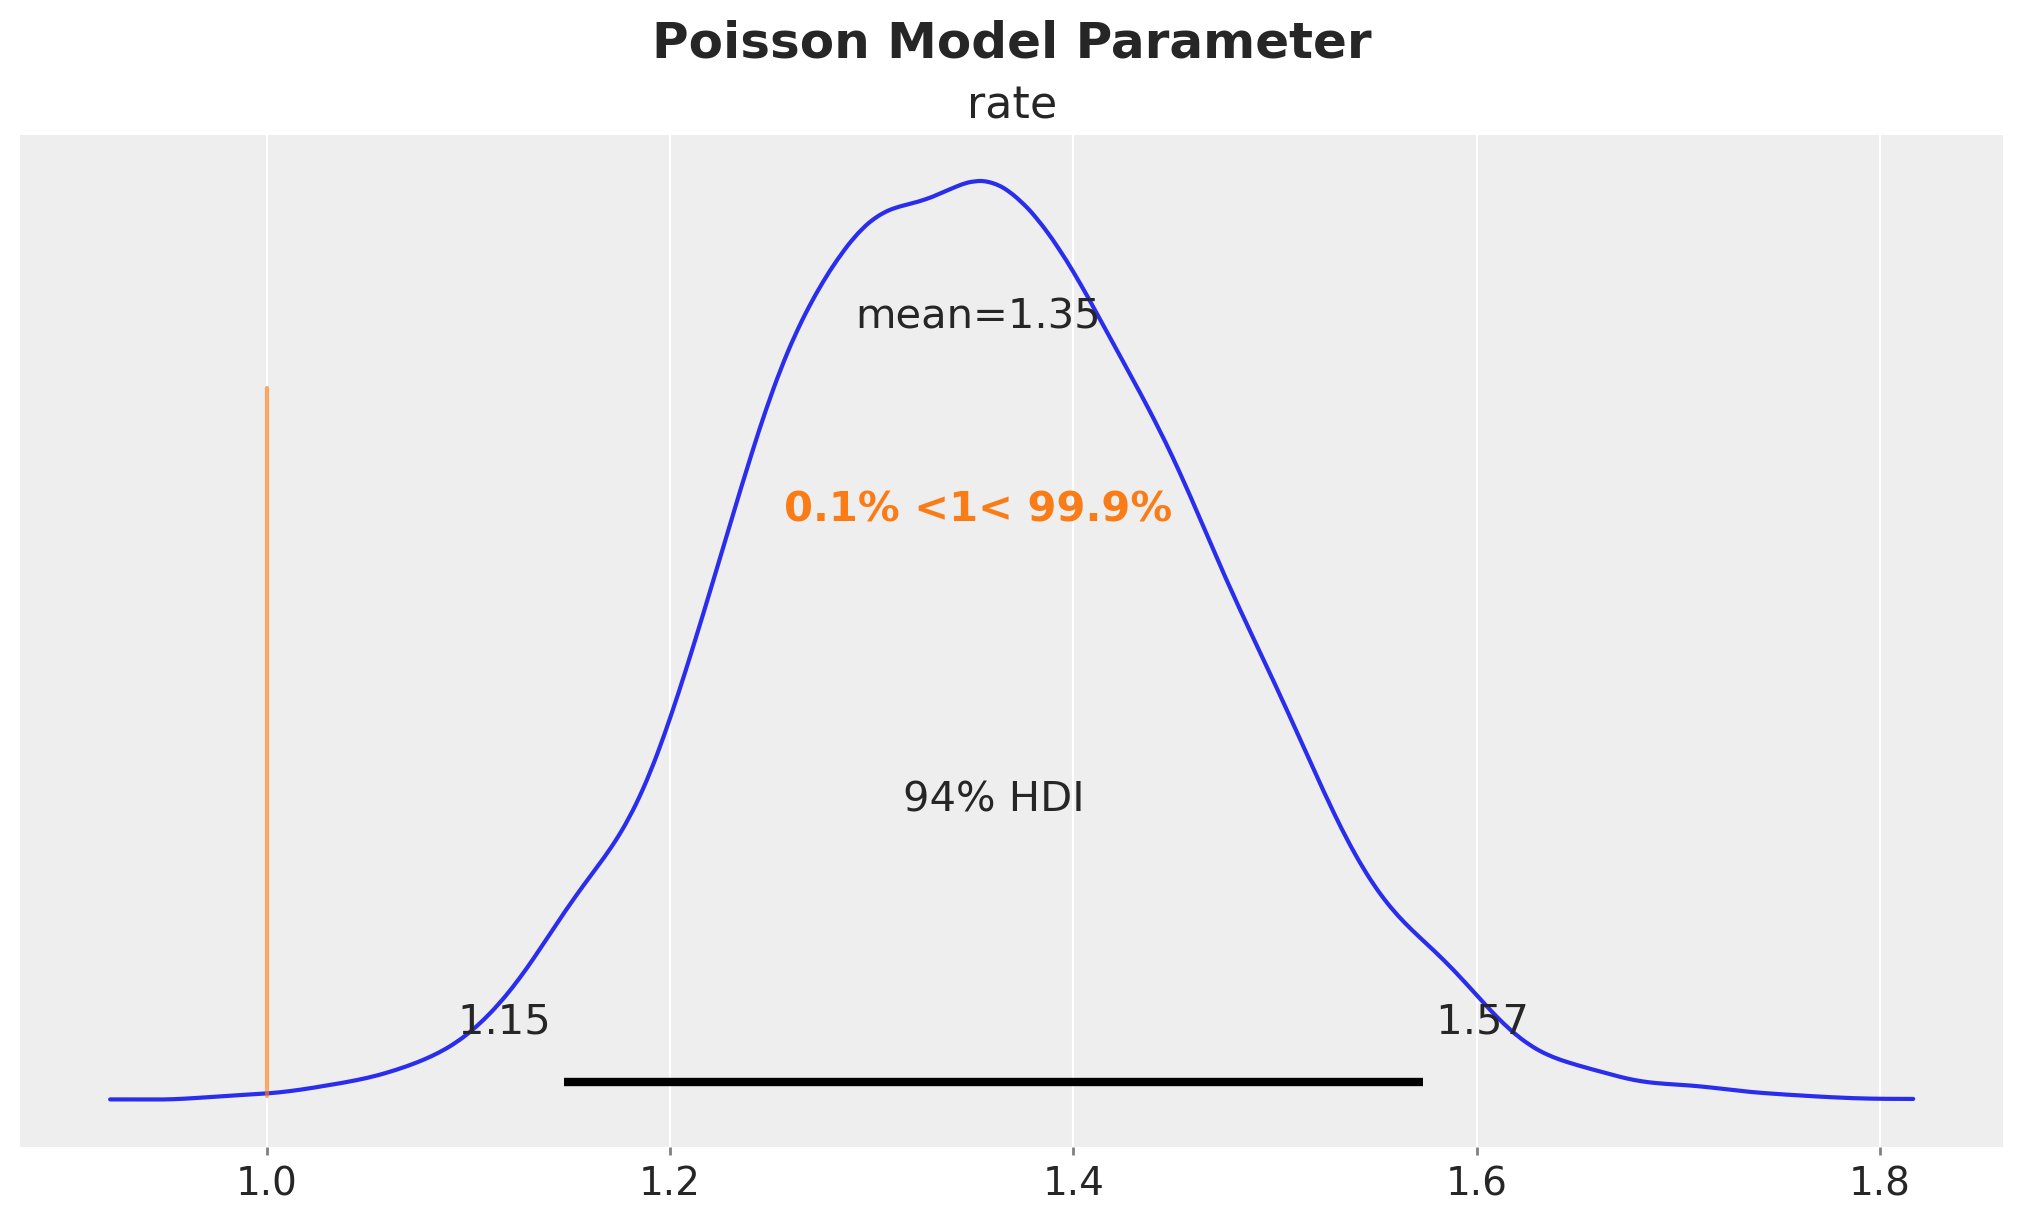

In [25]:
axes = az.plot_posterior(
    data=poisson_idata,
    ref_val=[censored_poisson_data_params.rate],
    round_to=3,
    figsize=(10, 6),
)
plt.gcf().suptitle("Poisson Model Parameter", fontsize=18, fontweight="bold");

We clearly see a bias in the estimation of the parameter. The true value of the rate parameter $\lambda$ is not even in the $94\%$ HDI.

We can also take a look into the posterior predictive distribution.

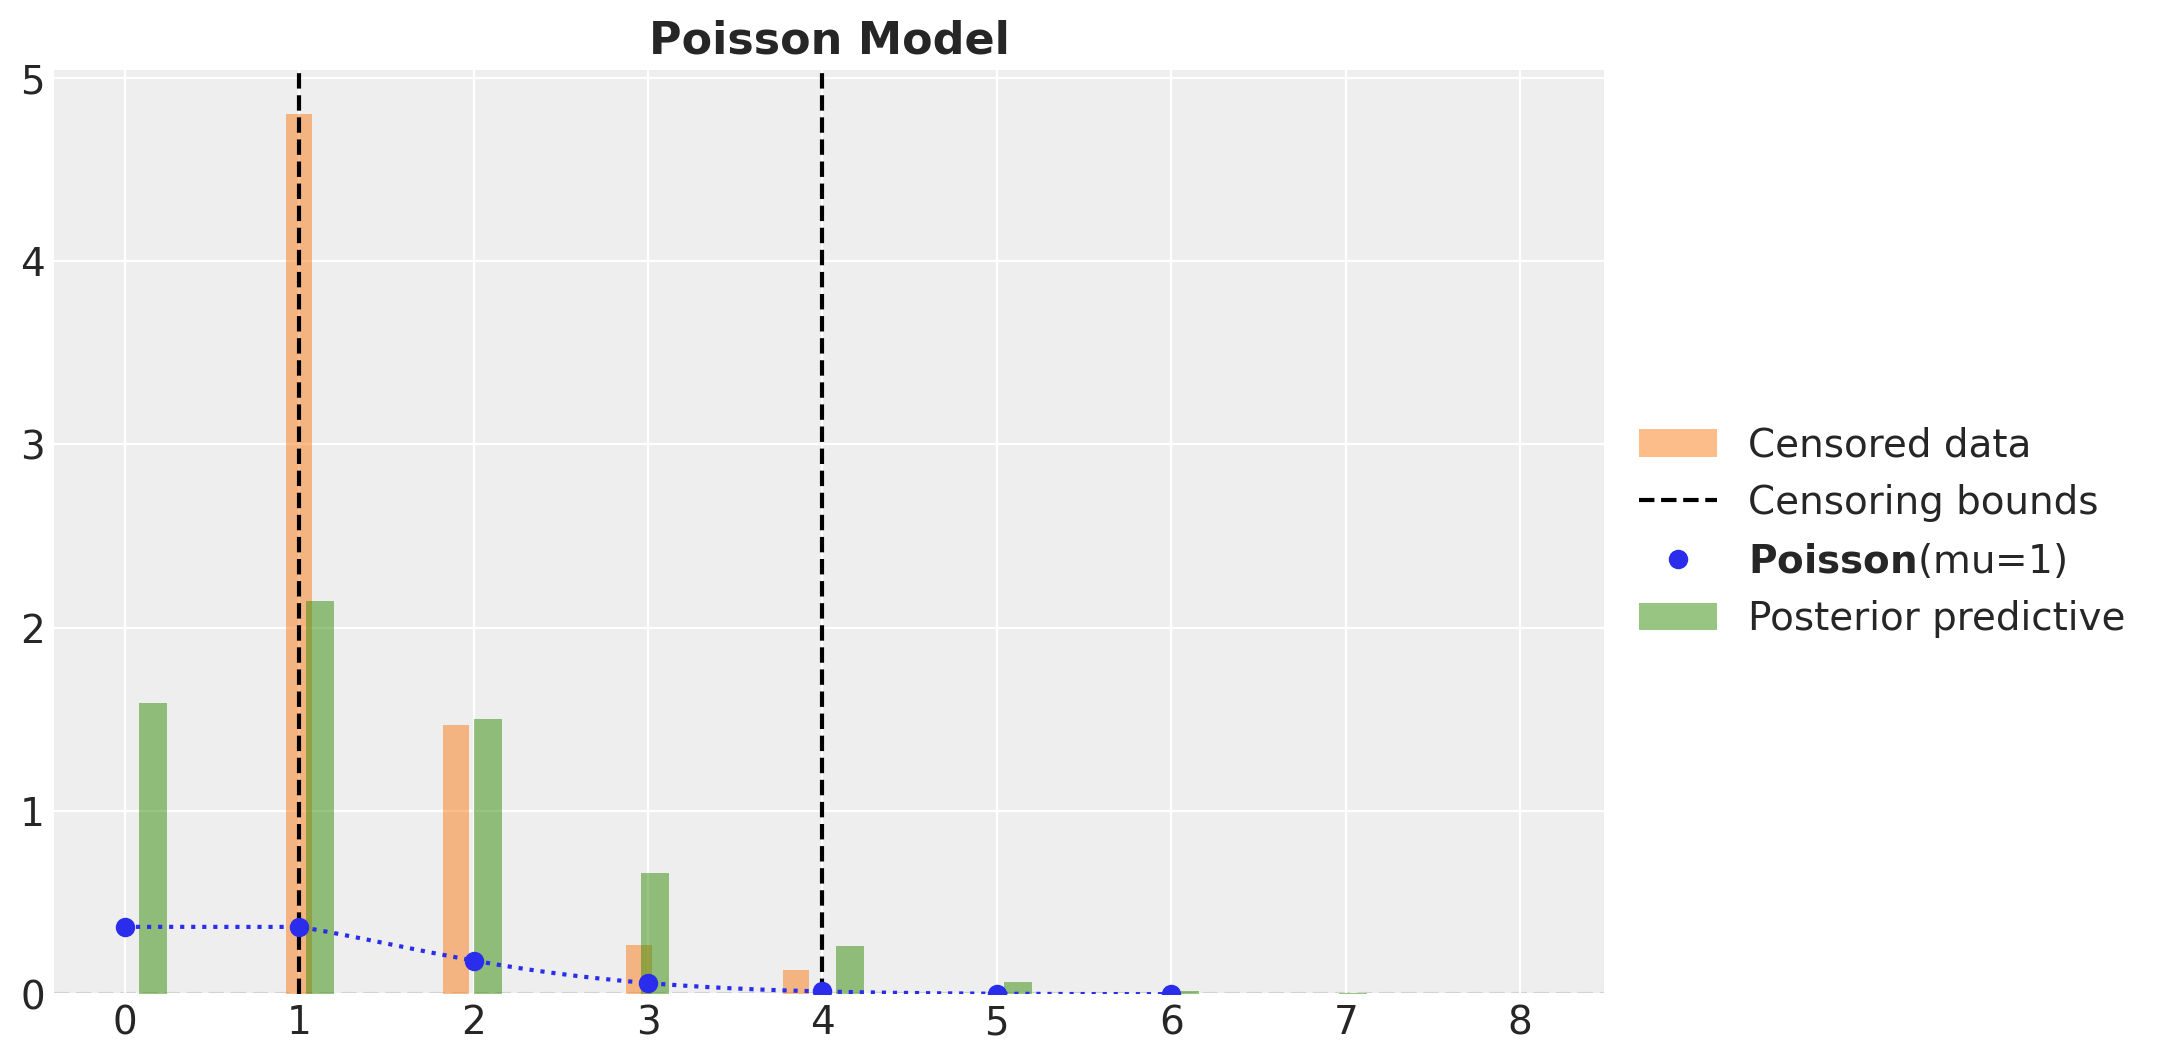

In [26]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_poisson_samples,
    bins=20,
    density=True,
    align="left",
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_poisson_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_poisson_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Poisson(mu=censored_poisson_data_params.rate).plot_pdf(color="C0", ax=ax)
_ = ax.hist(
    poisson_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    bins=50,
    density=True,
    align="right",
    color="C2",
    alpha=0.5,
    label="Posterior predictive",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Poisson Model", fontsize=16, fontweight="bold");

## Censored Poisson Model

Now we work out the censored model. As before, we need to get the censoring labels to manage the likelihood components:

In [27]:
truncation_label = get_truncation_label(
    y=censored_poisson_samples,
    lower=censored_poisson_data_params.lower,
    upper=censored_poisson_data_params.upper,
)

Now, finally regarding the detail about the upper censoring component. 

- We want to consider the **closed** interval $P(lower \leq y \leq upper)$.
- For the upper interval we use $1 - CDF(upper) = 1- P(y \leq upper) = P(y > upper)$, but we actually need $(P \geq upper)$. 
- Hence we need to add $P(y= upper)$ in the upper truncation probability.
- Observe that this discussion is irrelevant for the *continuous* case as the probability of a single point is zero so $P(y > upper) = P(y \geq upper)$.

The implementation of the model should be clearer now.

In [28]:
def censored_poisson_model(
    y: ArrayImpl, lower: float, upper: float, truncation_label: ArrayImpl
) -> None:
    rate = numpyro.sample("rate", dist.Exponential(1.0))

    distribution = dist.Poisson(rate)

    with mask(mask=truncation_label == -1):
        truncation_prob_lower = distribution.cdf(lower)
        numpyro.sample(
            "truncated_label_lower", dist.Bernoulli(truncation_prob_lower), obs=1
        )

    with mask(mask=truncation_label == 0):
        numpyro.sample("obs", distribution, obs=y)

    with mask(mask=truncation_label == 1):
        ccdf_upper = 1 - distribution.cdf(upper)
        pmf_upper = jnp.exp(distribution.log_prob(upper))
        truncation_prob_upper = ccdf_upper + pmf_upper
        numpyro.sample(
            "truncated_label_upper", dist.Bernoulli(truncation_prob_upper), obs=1
        )

**Remark:** This was an important detail pointed out by [Kyle Caron](https://kylejcaron.github.io/) in his blog post ["Modeling Anything With First Principles: Demand under extreme stockouts"](https://kylejcaron.github.io/posts/censored_demand/2024-02-06-censored-demand.html).

We proceed to fit the model and compare the results with the true parameter.

In [29]:
censored_poisson_kernel = NUTS(censored_poisson_model)
censored_poisson_mcmc = MCMC(
    censored_poisson_kernel,
    num_warmup=inference_params.num_warmup,
    num_samples=inference_params.num_samples,
    num_chains=inference_params.num_chains,
)
rng_key, rng_subkey = random.split(rng_key)
censored_poisson_mcmc.run(
    rng_key,
    y=censored_poisson_samples,
    lower=censored_poisson_data_params.lower,
    upper=censored_poisson_data_params.upper,
    truncation_label=truncation_label,
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [30]:
censores_poisson_predictive = Predictive(
    model=censored_poisson_model,
    posterior_samples=censored_poisson_mcmc.get_samples(),
    return_sites=["obs"],
)
rng_key, rng_subkey = random.split(rng_key)
censored_poisson_posterior_predictive = censores_poisson_predictive(
    rng_subkey,
    y=None,
    lower=censored_poisson_data_params.lower,
    upper=censored_poisson_data_params.upper,
    truncation_label=truncation_label,
)

censored_poisson_idata = az.from_numpyro(posterior=censored_poisson_mcmc)
censored_poisson_idata.extend(
    az.from_numpyro(posterior_predictive=censored_poisson_posterior_predictive)
)

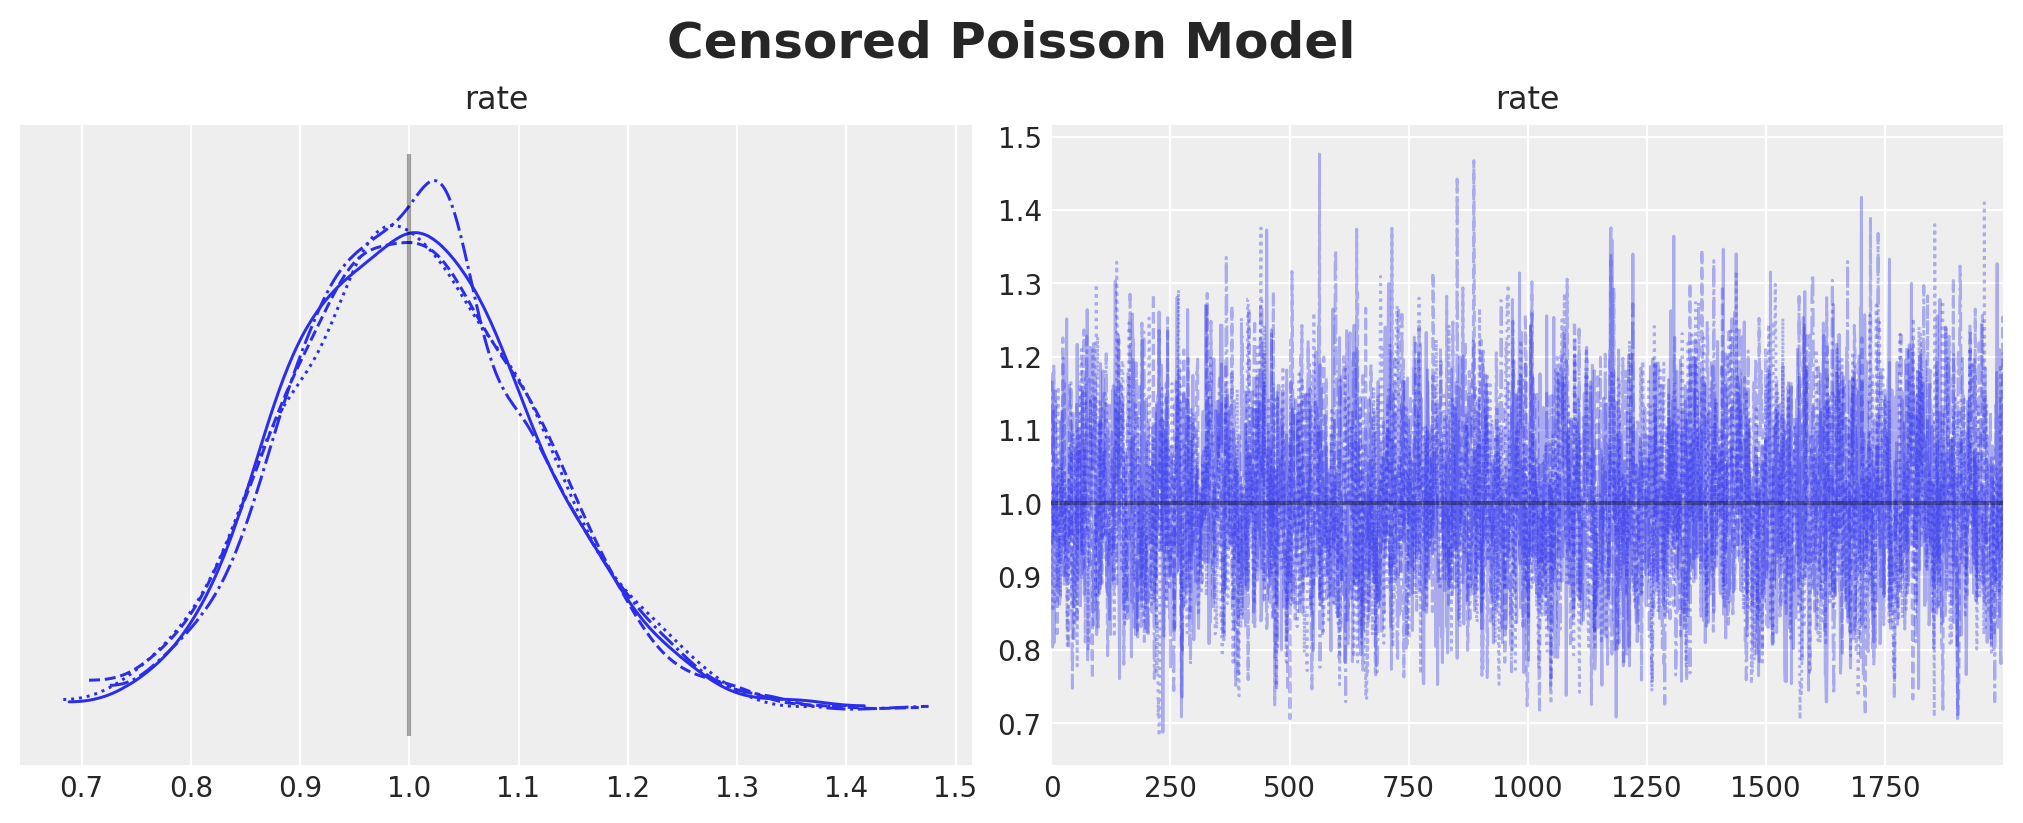

In [31]:
axes = az.plot_trace(
    data=censored_poisson_idata,
    compact=True,
    lines=[("rate", {}, censored_poisson_data_params.rate)],
    backend_kwargs={"figsize": (10, 4), "layout": "constrained"},
)
plt.gcf().suptitle("Censored Poisson Model", fontsize=18, fontweight="bold");

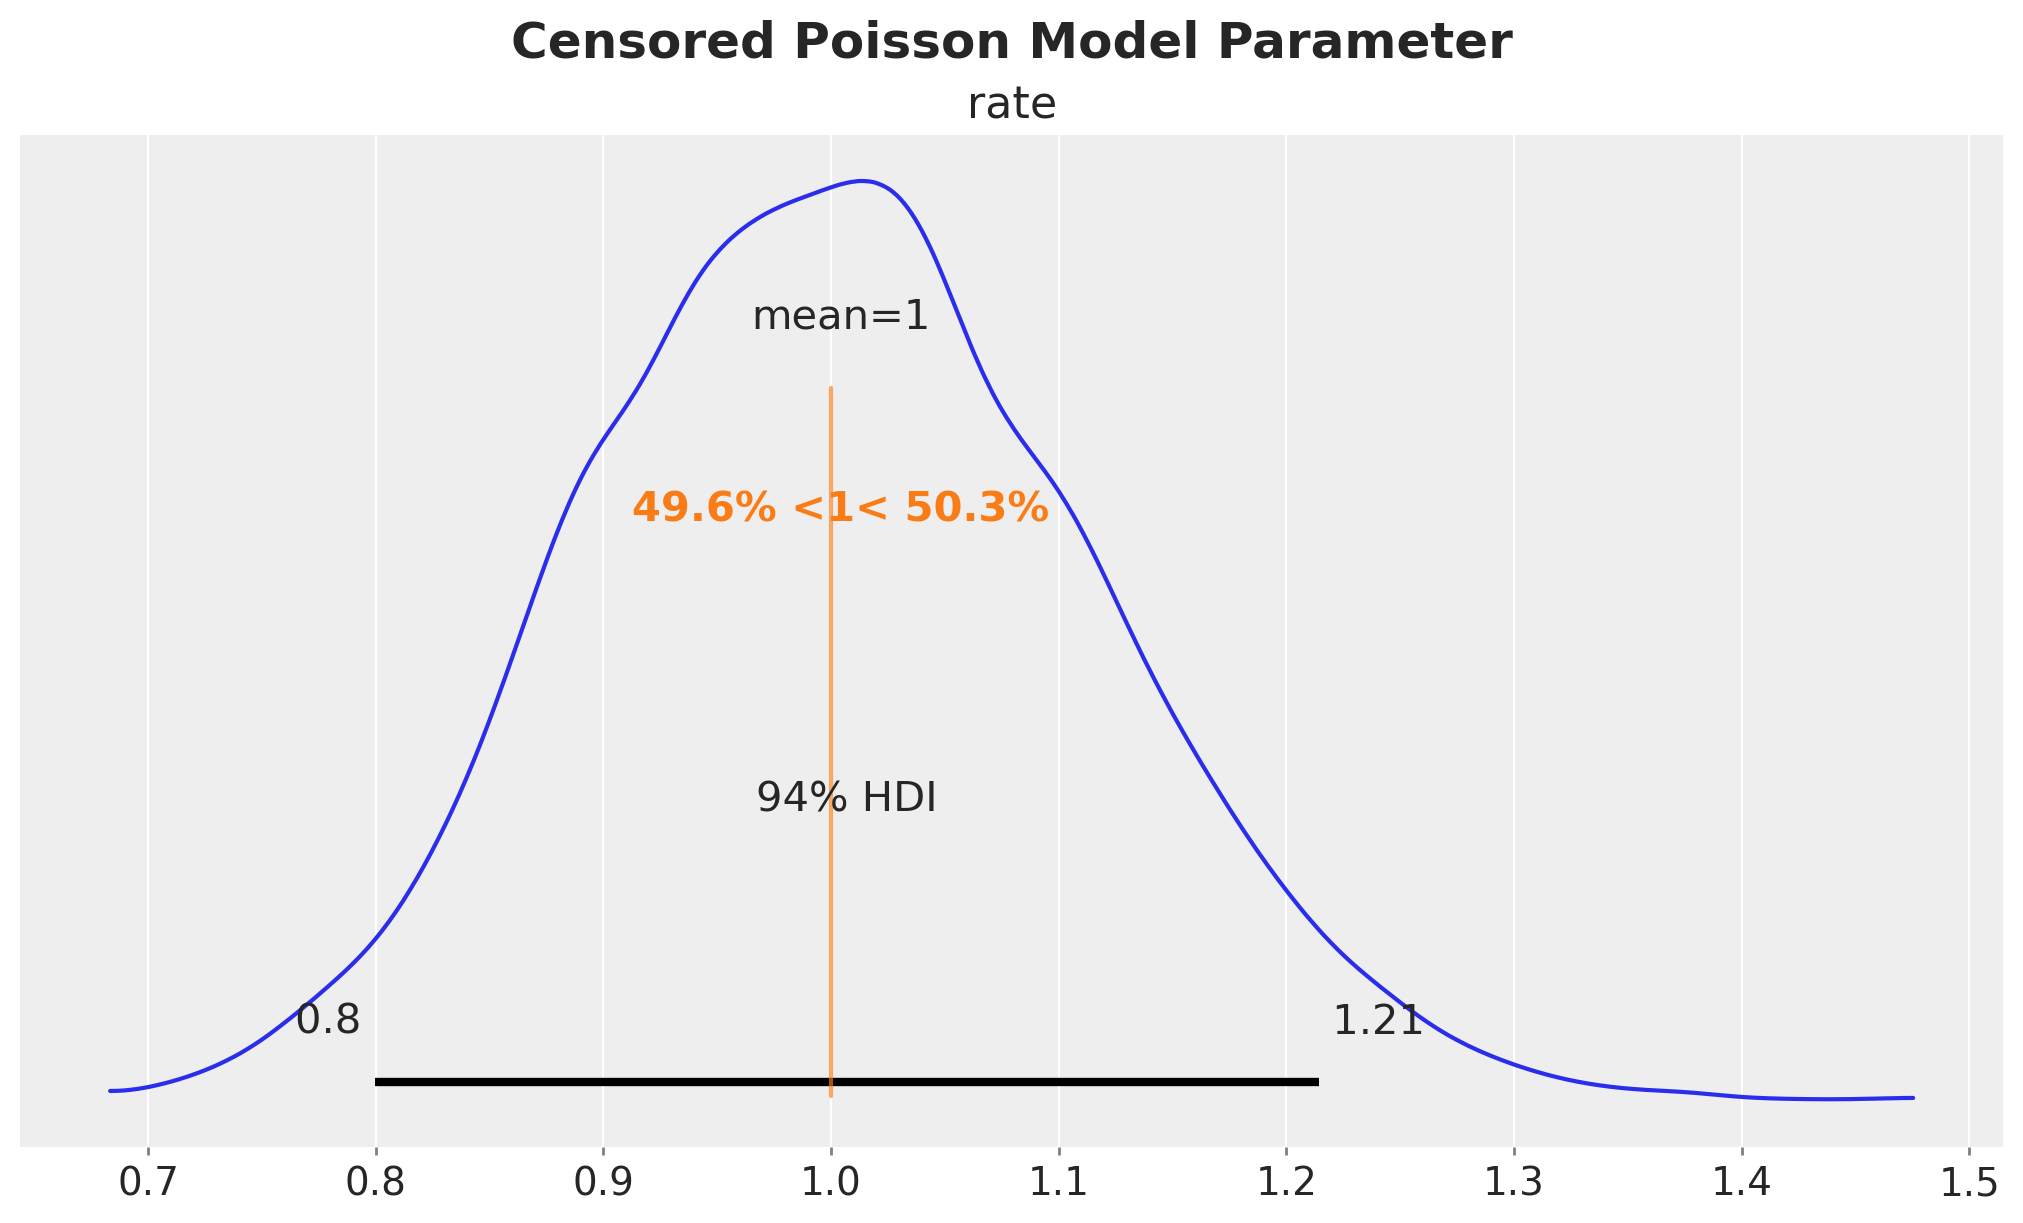

In [32]:
axes = az.plot_posterior(
    data=censored_poisson_idata,
    ref_val=[censored_poisson_data_params.rate],
    round_to=3,
    figsize=(10, 6),
)
plt.gcf().suptitle("Censored Poisson Model Parameter", fontsize=18, fontweight="bold");

We see that we have recovered the true value of the rate parameter $\lambda = 1$.

Here is the posterior predictive distribution:

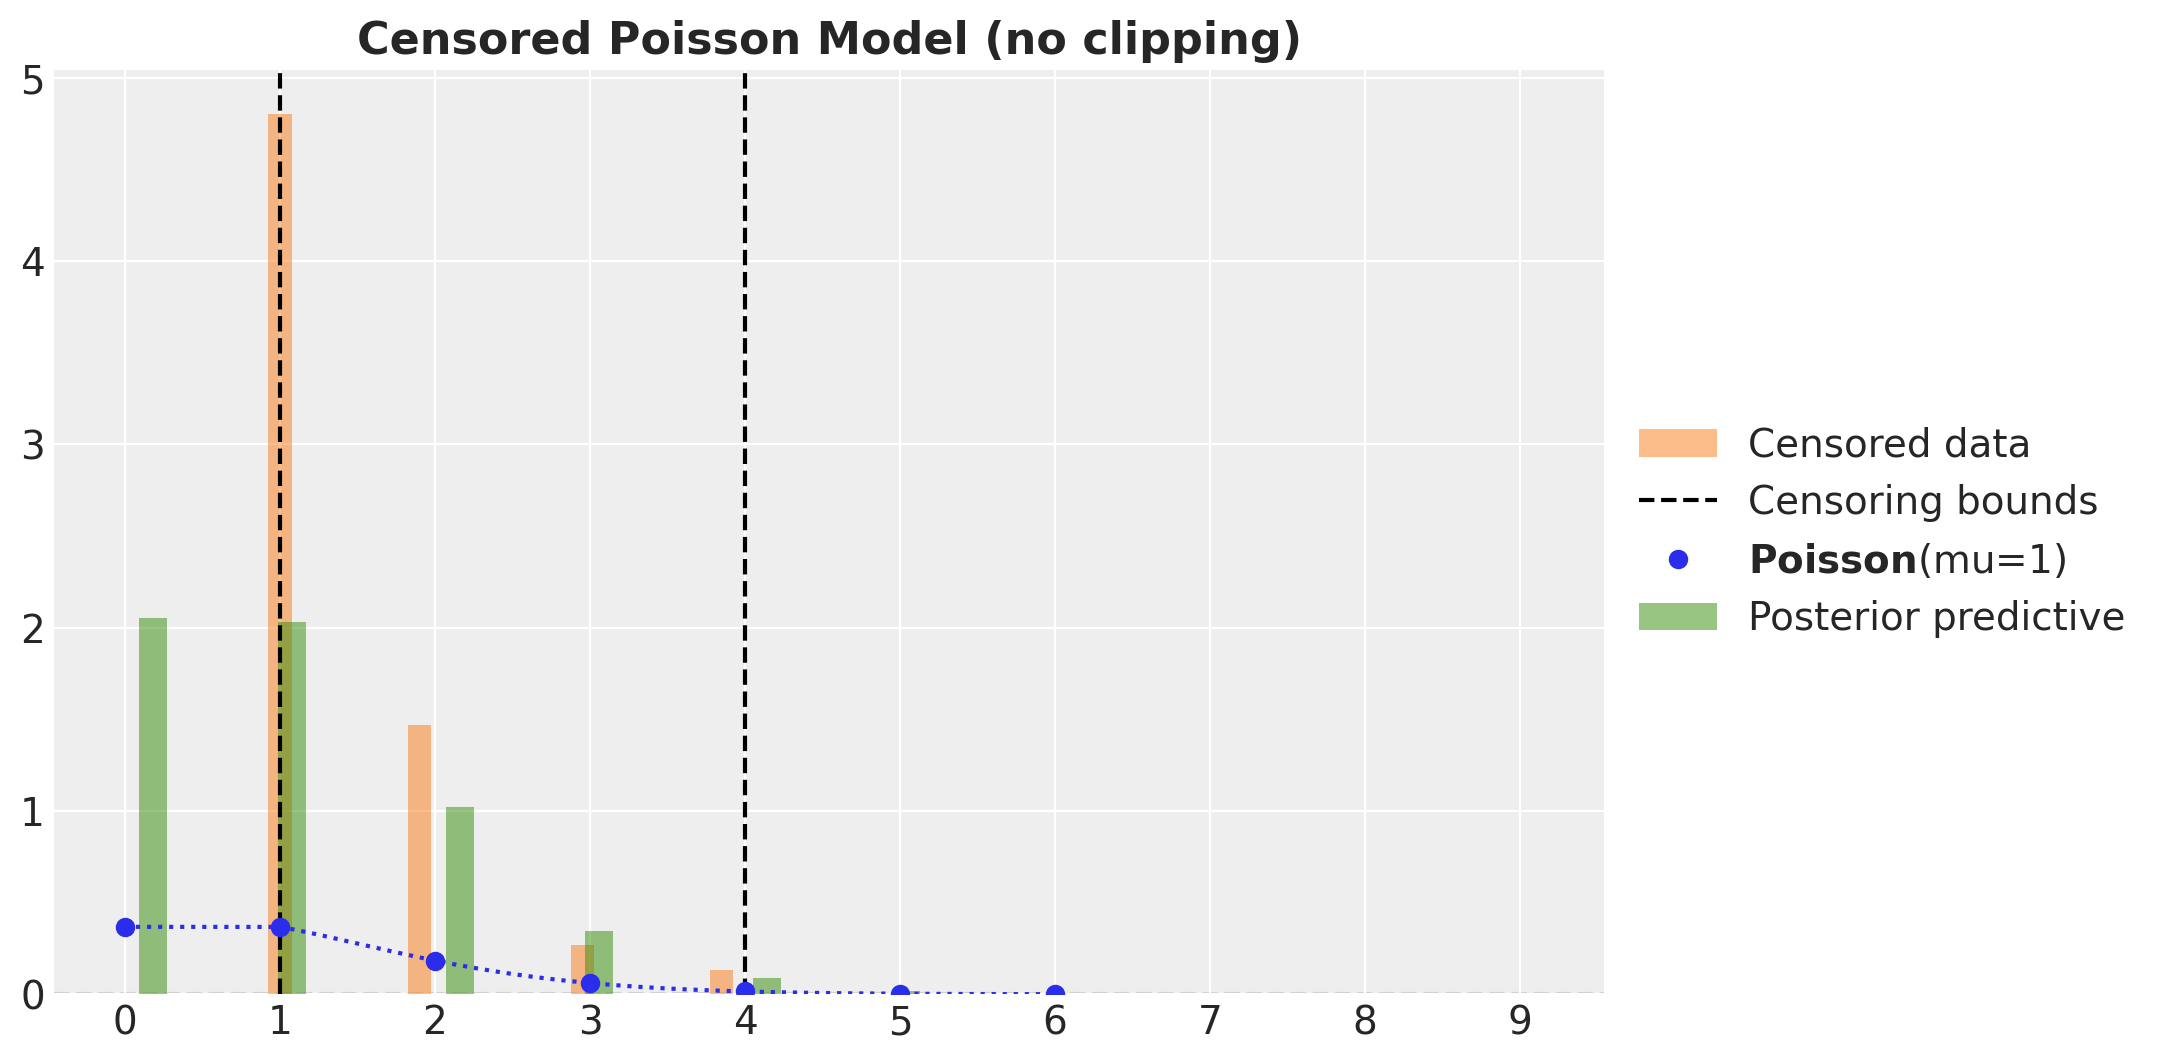

In [33]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_poisson_samples,
    bins=20,
    density=True,
    align="left",
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_poisson_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_poisson_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Poisson(mu=censored_poisson_data_params.rate).plot_pdf(color="C0", ax=ax)
_ = ax.hist(
    censored_poisson_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    bins=50,
    density=True,
    align="right",
    color="C2",
    alpha=0.5,
    label="Posterior predictive",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Poisson Model (no clipping)", fontsize=16, fontweight="bold");

As before, to have a correct posterior predictive distribution we need to clip the samples to the bounds.

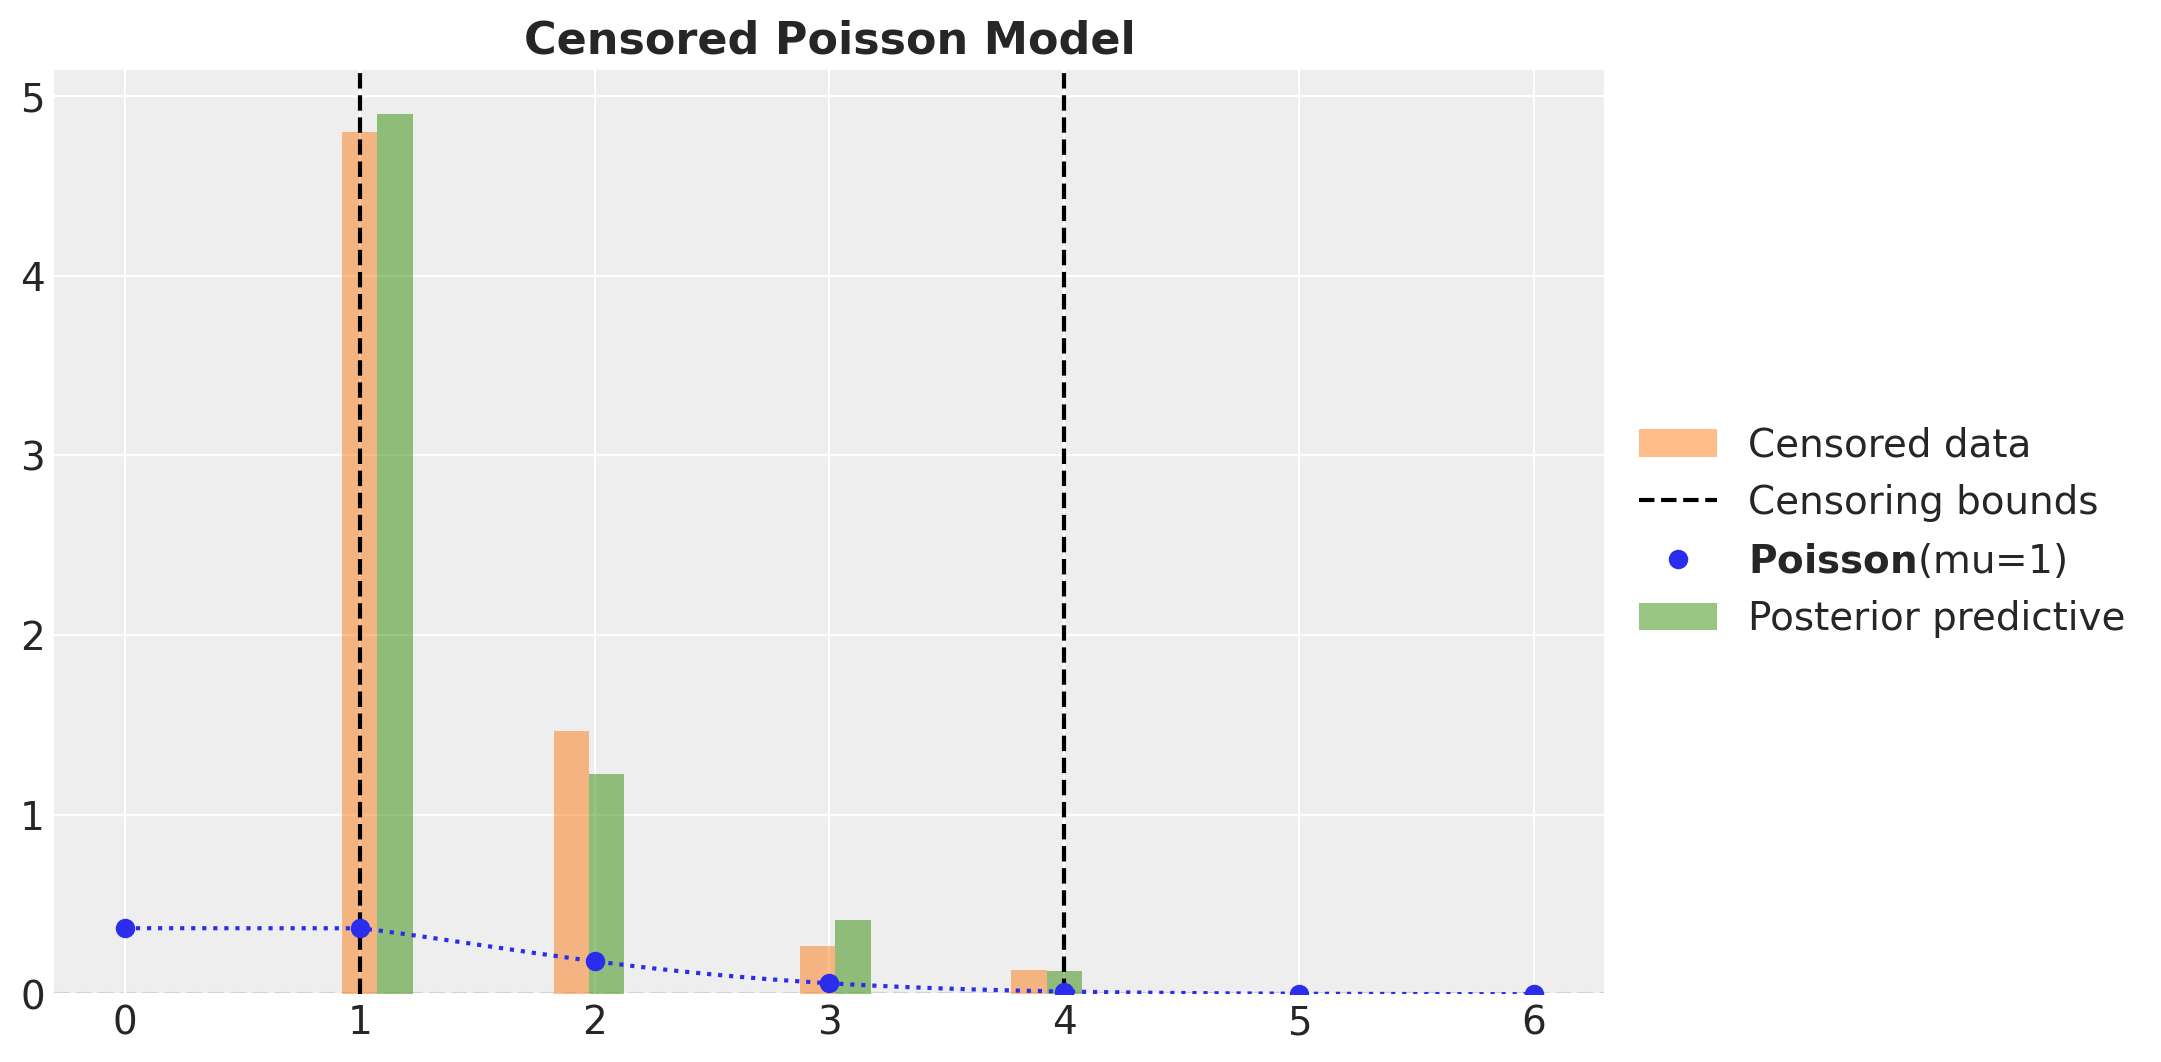

In [34]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_poisson_samples,
    bins=20,
    density=True,
    align="left",
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_poisson_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_poisson_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Poisson(mu=censored_poisson_data_params.rate).plot_pdf(color="C0", ax=ax)
_ = ax.hist(
    censored_poisson_idata["posterior_predictive"]["obs"]
    .clip(
        min=censored_poisson_data_params.lower, max=censored_poisson_data_params.upper
    )
    .to_numpy()
    .flatten(),
    bins=20,
    density=True,
    align="right",
    color="C2",
    alpha=0.5,
    label="Posterior predictive",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Poisson Model", fontsize=16, fontweight="bold");

Here we see that the observed and predicted distributions match well.

## Centered Poisson Model with PyMC

Finally, we fit the same model in PyMC and verify we get the same results as in NumPyro implementation. Note that we do not need to worry about the upper truncation probability extra term as PyMC takes care of this for us. This is very convenient.

In [35]:
with pm.Model() as pymc_censored_poisson_model:
    rate = pm.Exponential("rate", lam=1.0)
    pm.Censored(
        "obs",
        dist=pm.Poisson.dist(mu=rate),
        lower=censored_poisson_data_params.lower,
        upper=censored_poisson_data_params.upper,
        observed=censored_poisson_samples,
    )

In [36]:
rng_key, rng_subkey = random.split(rng_key)

with pymc_censored_poisson_model:
    pymc_censored_poisson_idata = pm.sample(
        tune=inference_params.num_warmup,
        draws=inference_params.num_samples,
        chains=inference_params.num_chains,
        nuts_sampler="numpyro",
        random_seed=rng_subkey[0].item(),
    )

    pymc_censored_poisson_idata.extend(
        pm.sample_posterior_predictive(trace=pymc_censored_poisson_idata)
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling: [obs]


Output()

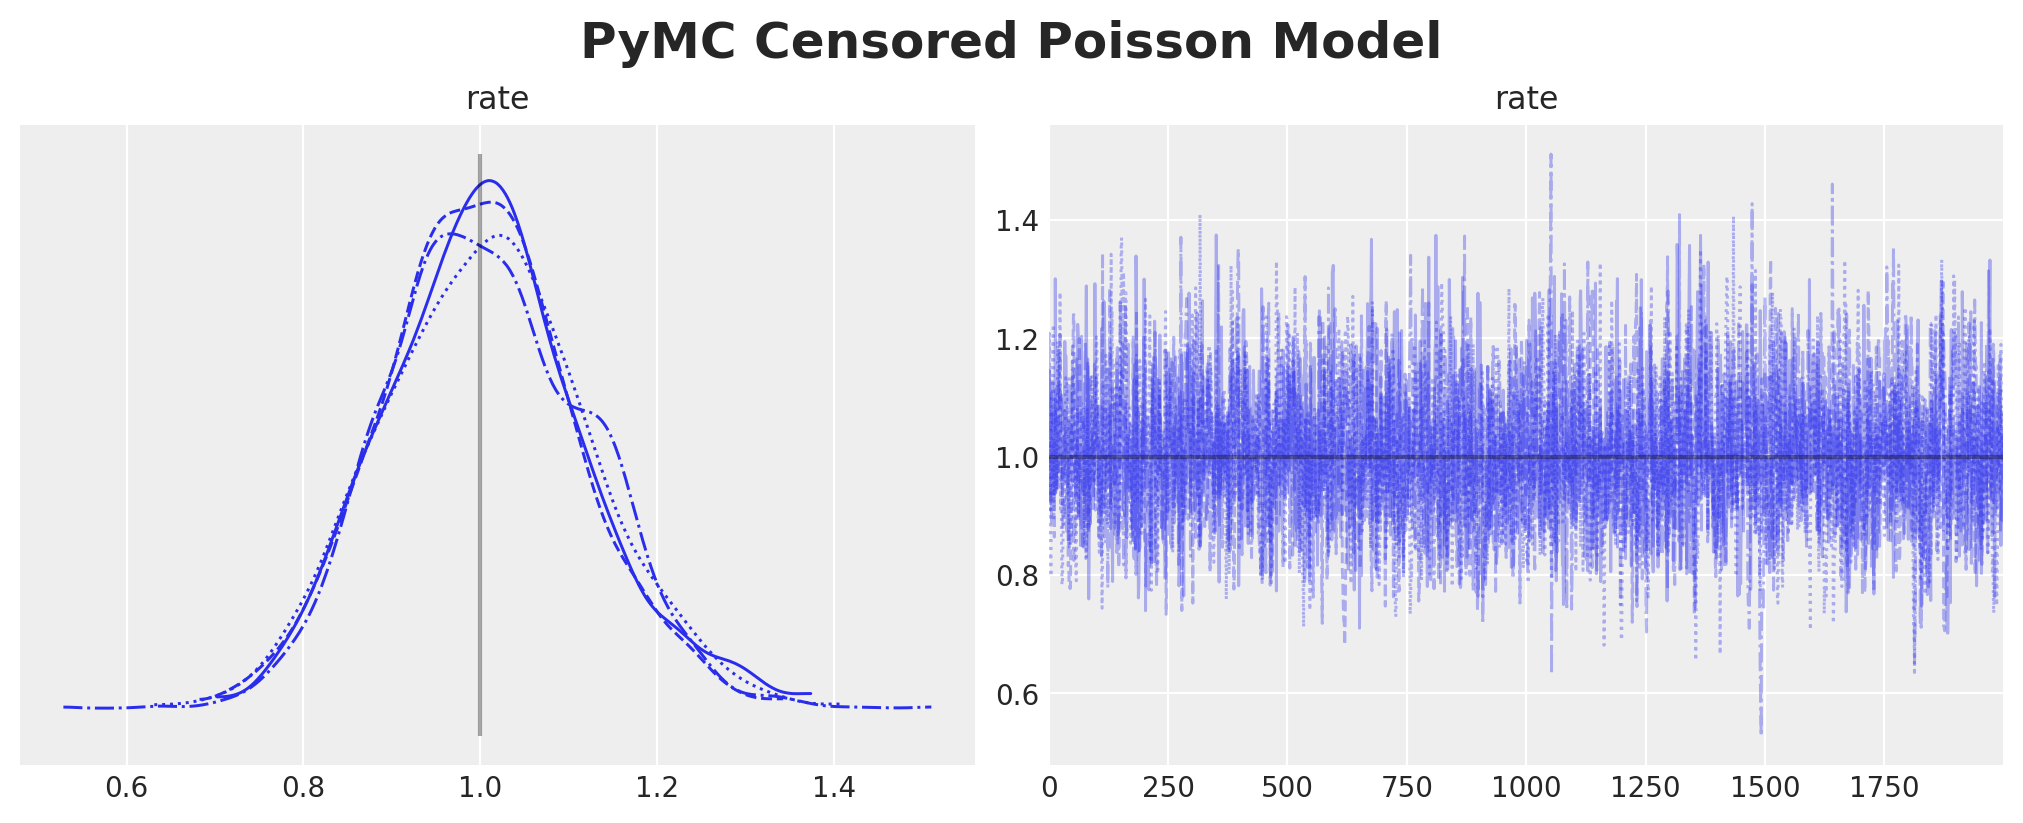

In [37]:
axes = az.plot_trace(
    data=pymc_censored_poisson_idata,
    compact=True,
    lines=[("rate", {}, censored_poisson_data_params.rate)],
    backend_kwargs={"figsize": (10, 4), "layout": "constrained"},
)
plt.gcf().suptitle("PyMC Censored Poisson Model", fontsize=18, fontweight="bold");

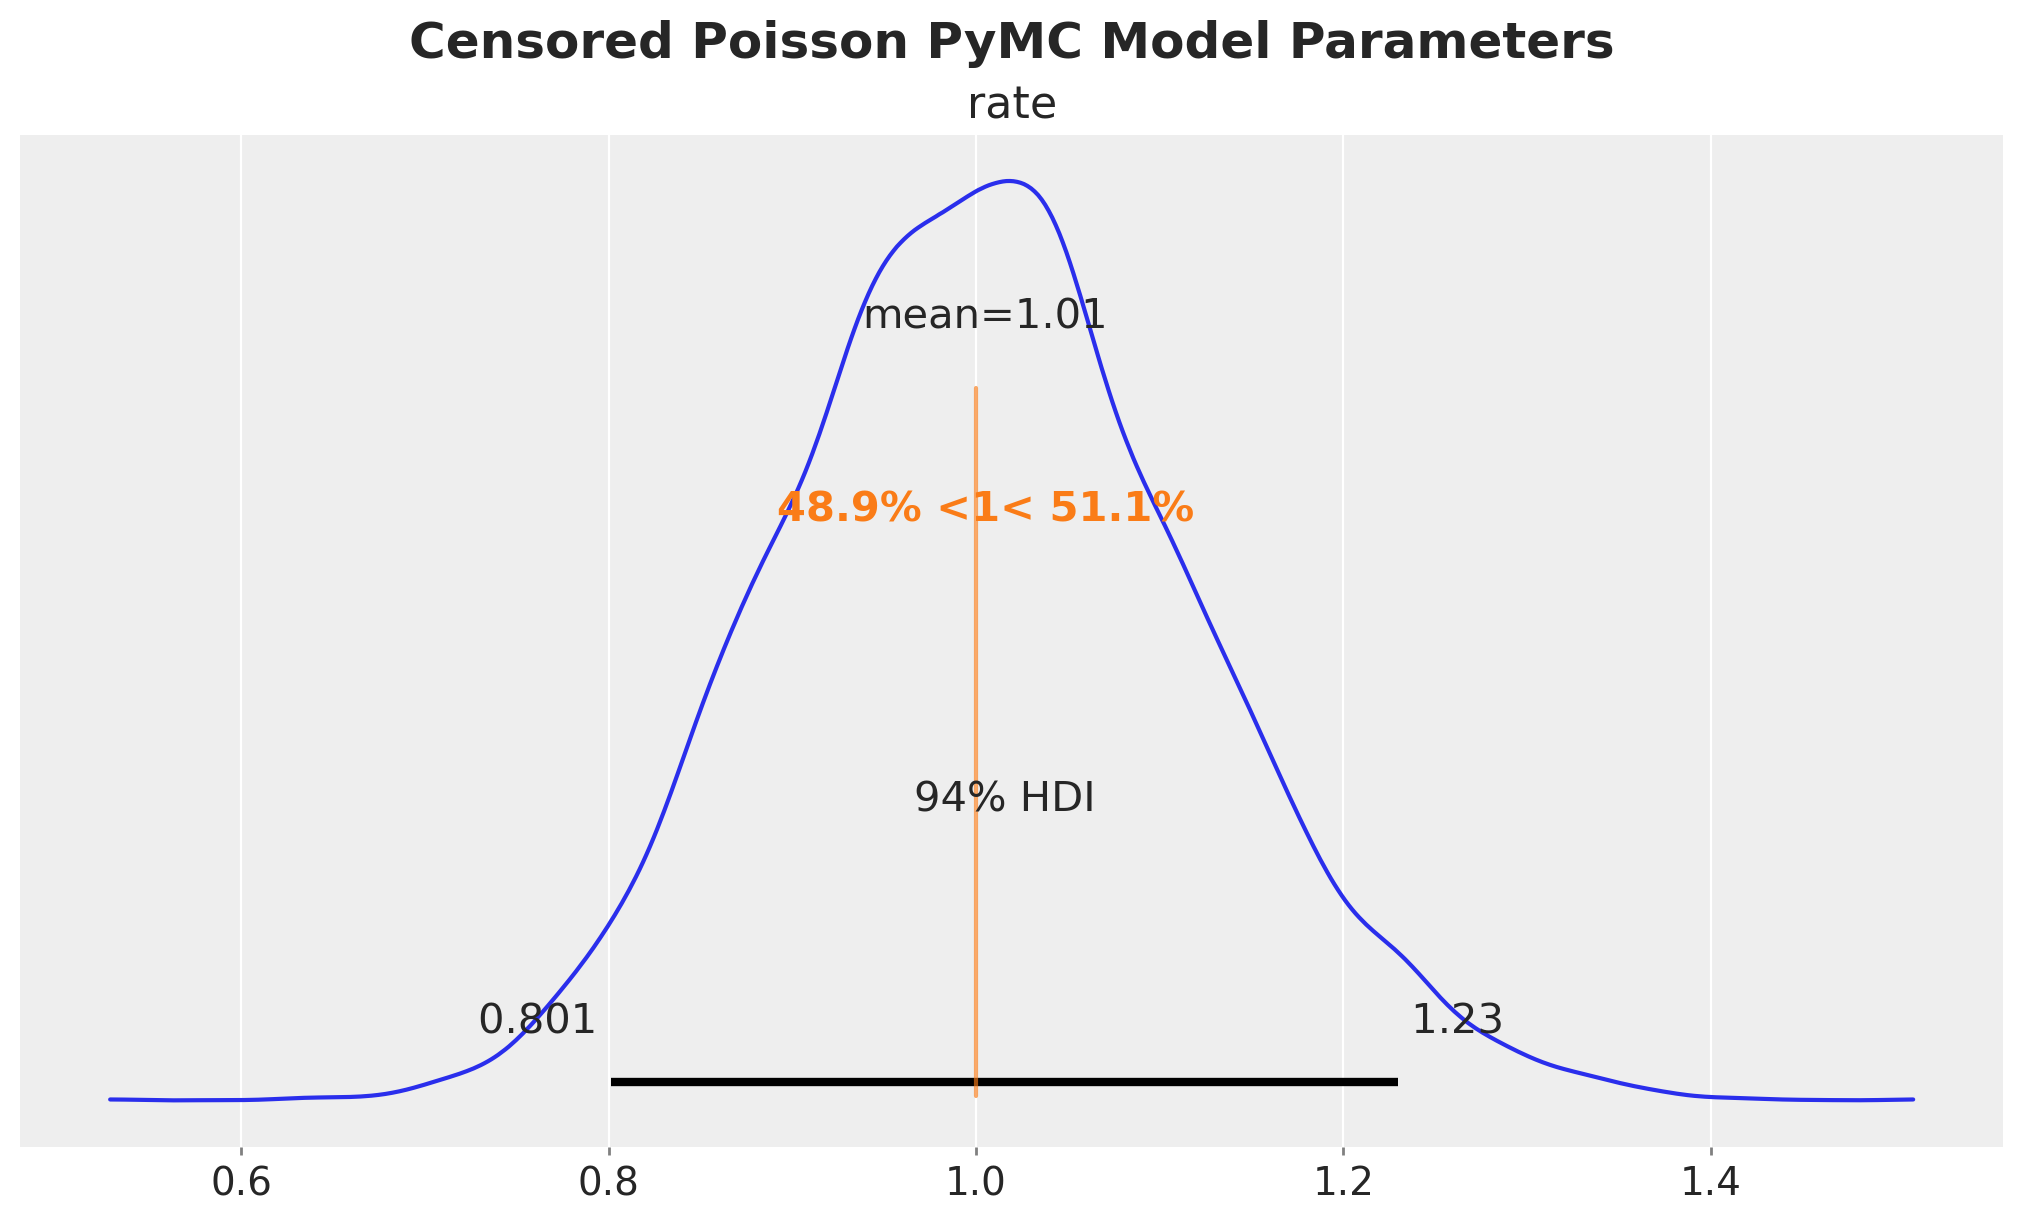

In [38]:
axes = az.plot_posterior(
    data=pymc_censored_poisson_idata,
    ref_val=[censored_poisson_data_params.rate],
    round_to=3,
    figsize=(10, 6),
)
plt.gcf().suptitle(
    "Censored Poisson PyMC Model Parameters", fontsize=18, fontweight="bold"
);

We indeed get the same results as the NumPyro implementation.

As in the continuous case we verify that we get the expected results for the posterior predictive distribution for the censored model in PyMC.

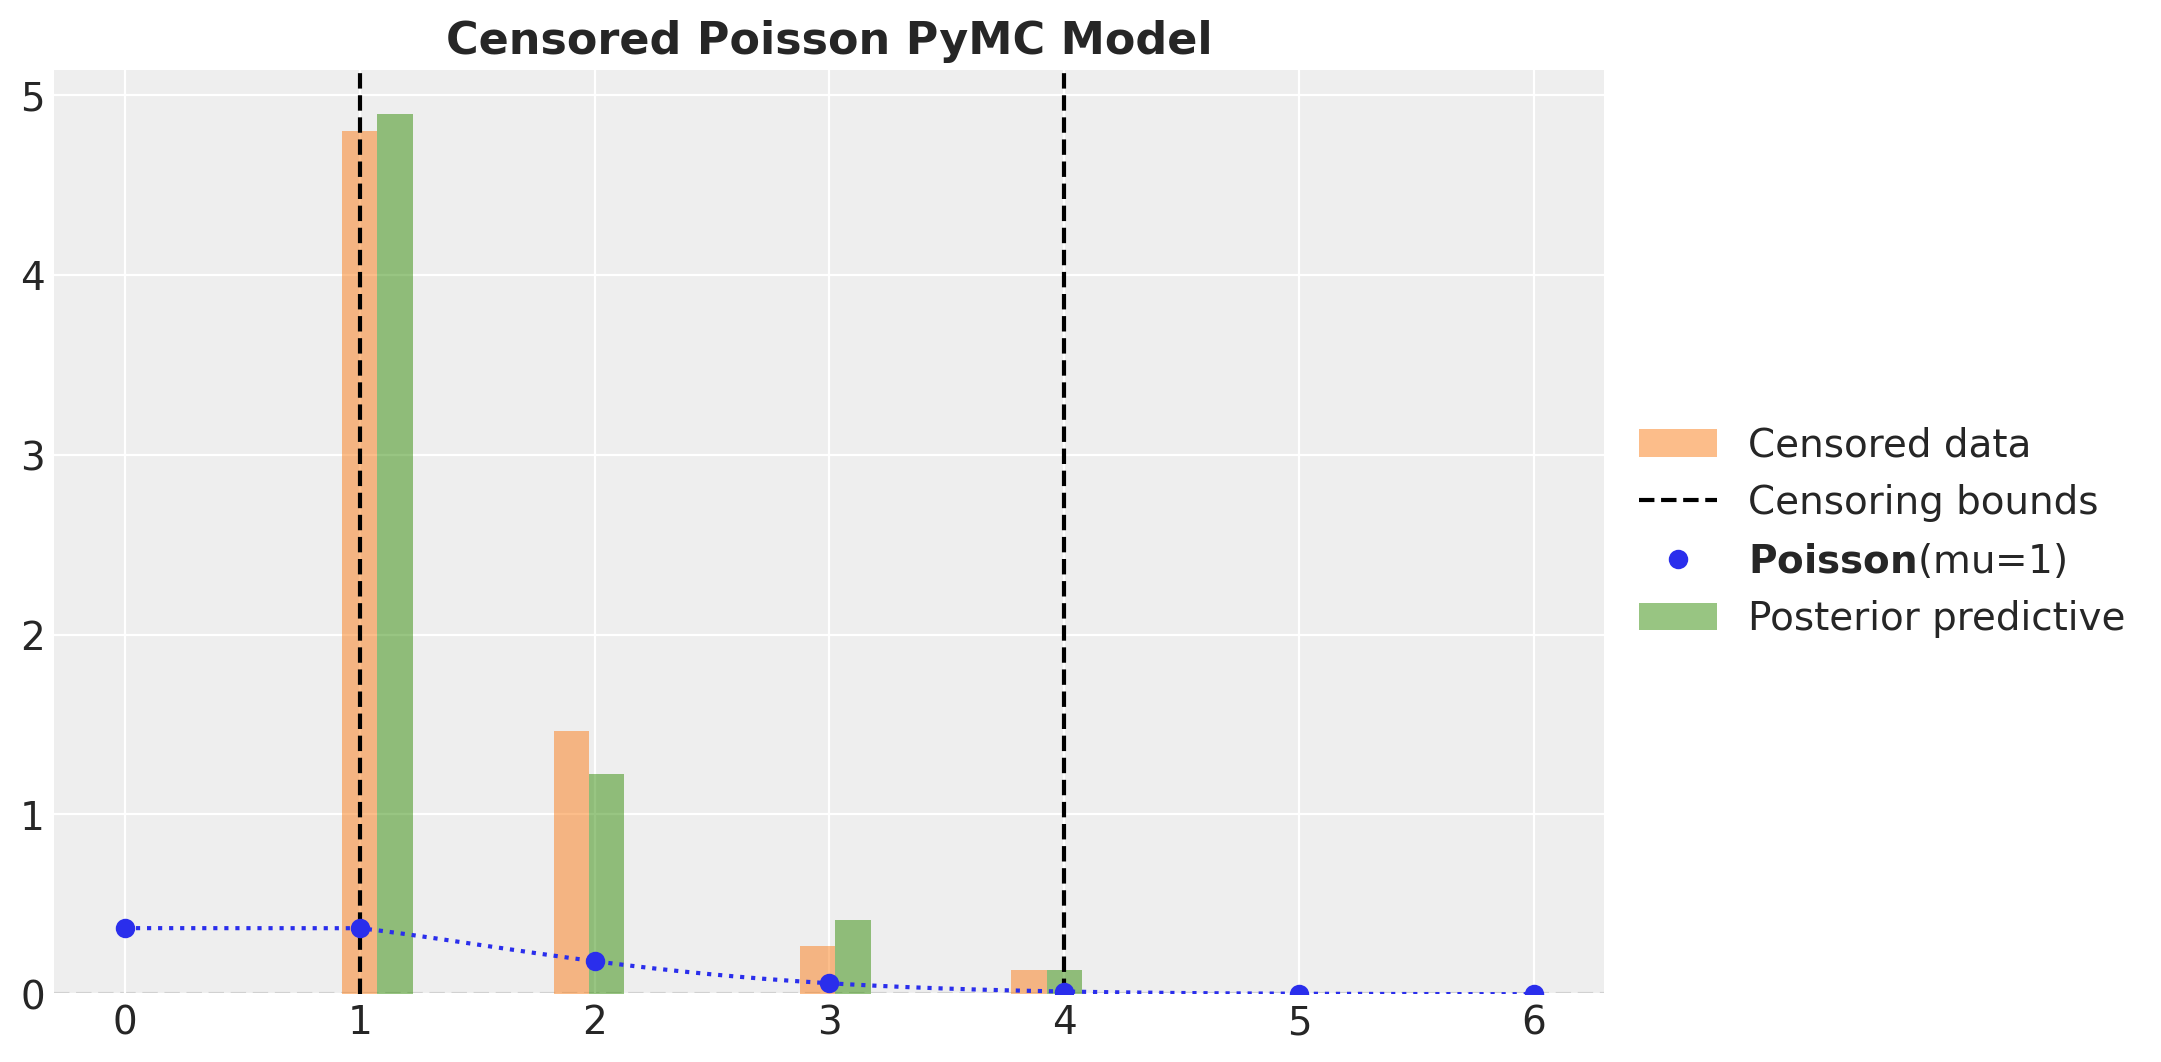

In [39]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_poisson_samples,
    bins=20,
    density=True,
    align="left",
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_poisson_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_poisson_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Poisson(mu=censored_poisson_data_params.rate).plot_pdf(color="C0", ax=ax)
_ = ax.hist(
    pymc_censored_poisson_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    bins=20,
    density=True,
    align="right",
    color="C2",
    alpha=0.5,
    label="Posterior predictive",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Poisson PyMC Model", fontsize=16, fontweight="bold");

---

Censoring is an important concept in many fields and it is important to take it into account when modeling data. We have shown how to implement a censoring model in both NumPyro and PyMC. We have also shown how to implement the model for both continuous and discrete distributions. We hope this notebook is useful for those who want to learn how to implement censoring models in these two popular probabilistic programming libraries. I will be exploring more censoring models in the context of time series and supply chain management applications (again thanks to Kyle Caron for the inspiration).